# Setup

In [1]:
setwd("/project/kohl_analysis/analysis/CAdir/results/results/")
source("./utils.R")
renv::load("/project/kohl_analysis/analysis/CAdir")
devtools::load_all("/home/kohl/PhD/gits/ClemensKohl/CAdir")

suppressPackageStartupMessages({
  library(APL)
  library(SingleCellExperiment)
  library(dplyr)

  # To load the data set
  library(TENxPBMCData)
  library(Seurat)
  library(SeuratObject)
  library(scater)
  library(scuttle)
  library(scran)

  library(patchwork)
  library(ggtext)
})

options(repr.plot.width = 20, repr.plot.height = 15)

dir <- "/project/kohl_analysis/analysis/CAdir/results/results/"
imgdir <- file.path(dir, "img/figure1/")
dir.create(imgdir, recursive = TRUE)

The following package(s) are missing entries in the cache:
- quarto
These packages will need to be reinstalled.

The following package(s) have broken symlinks into the cache:
- quarto
Use `renv::repair()` to try and reinstall these packages.

- The project is out-of-sync -- use `renv::status()` for details.


ℹ Loading CAdir






Warning message in dir.create(imgdir, recursive = TRUE):
“'/project/kohl_analysis/analysis/CAdir/results/results//img/figure1' already exists”


## Load data

In [2]:
data_dir <- "/project/kohl_analysis/analysis/CAdir/results/data/real/discussed/"

marker_genes <- readr::read_csv(file.path(data_dir, "tabula_muris_marker_genes.csv"))
sce <- readRDS(file.path(data_dir, "preprocessed/tabula_muris_preprocessed_filtered.rds"))

genevars <- modelGeneVar(sce, assay.type = "logcounts")
chosen <- getTopHVGs(genevars, n = 6000, var.threshold = NULL)

# add marker_genes
expr_markers <- marker_genes[marker_genes$gene %in% rownames(sce), ]
chosen <- c(chosen, expr_markers$gene)
chosen <- unique(chosen)
sce_sub <- sce[chosen, ]

ca <- cacomp(obj = logcounts(sce_sub),
             princ_coords = 3,
             dims = 30,
             top = nrow(sce_sub),
             residuals = "pearson",
             python = TRUE)

cell_types <- sce$cell_ontology_class
cat("Number of cell types:", length(unique(cell_types)), "\n")

Rows: 19 Columns: 2
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (2): cell_type, gene

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Number of cell types: 8 


# CAdir

In [3]:
set.seed(2358)
cak <- dirclust_splitmerge(
    caobj = ca,
    k = 8,
    cutoff = 55,
    method = "random",
    apl_quant = 0.99,
    counts = NULL,
    min_cells = 20,
    reps = 5,
    make_plots = TRUE,
    qcutoff = 0.8
)

Iteration 1
	Merging cluster_1 with cluster_4
	Merging cluster_2 with cluster_6
Iteration 2
Iteration 3
Iteration 4
Iteration 5
	Splitting cluster cluster_2


Annotate biclustering:

In [4]:
cak <- annotate_biclustering(obj = cak,
                                universe = rownames(sce_sub),
                                org = "mm")

sce_sub$cadir <- cak@cell_clusters

cak

caclust object with 1882 cells and 1200 genes.
7 clusters found.
Clustering results:

 cluster                   ncells ngenes
 cluster_1                 940     45   
 Vascular_endothelial_cell 187    270   
 B_cell                    113    200   
 T_cell                     48    192   
 Immune_cell                76    203   
 Schwalie_et_al.Nature.P1  490    106   
 Endothelial_cell           28    184   

ARI: 0.6695187

Saving 6.67 x 6.67 in image


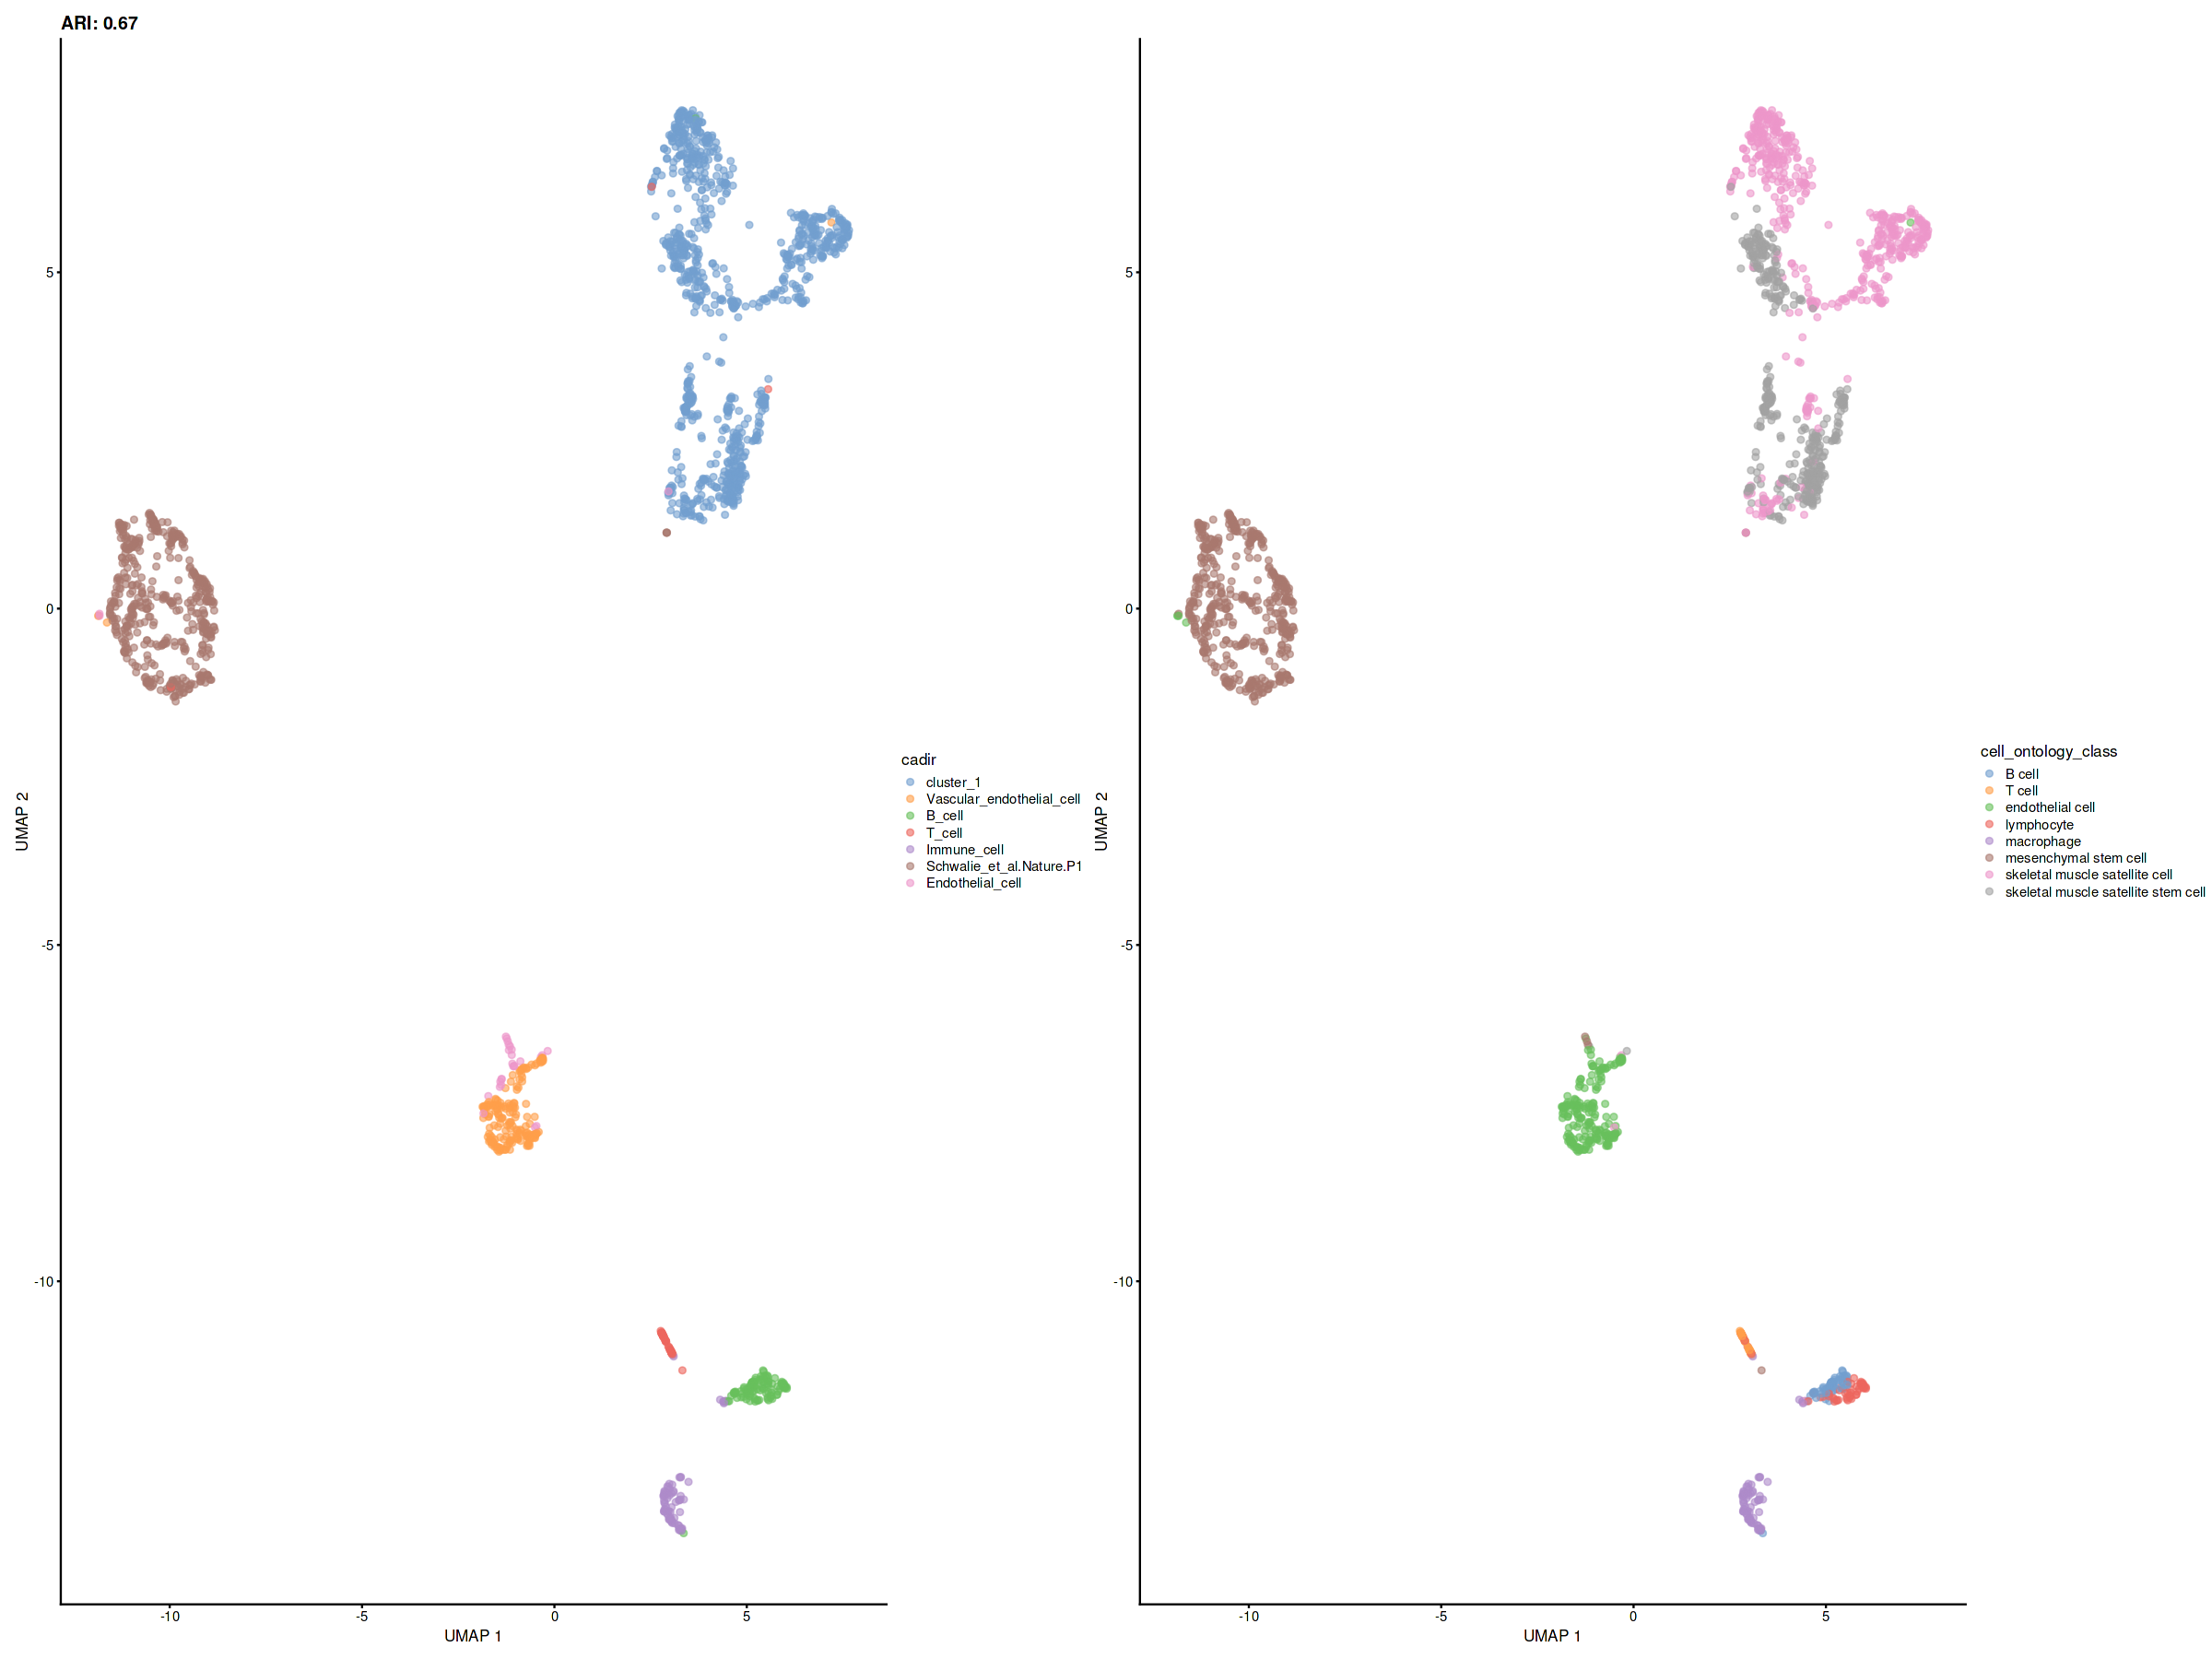

In [5]:
um1 <- plotUMAP(sce_sub, colour = "cadir")
um2 <- plotUMAP(sce_sub, colour = "cell_ontology_class")

ari <- aricode::clustComp(sce_sub$cadir, sce_sub$cell_ontology_class)
cat("ARI:", ari$ARI)

um <- um1 + ggtitle(paste0("ARI: ", round(ari$ARI, 2))) + um2
um

ggsave(
  plot = um,
  filename = file.path(imgdir, "umap.png")
)

# Cluster Association Plots

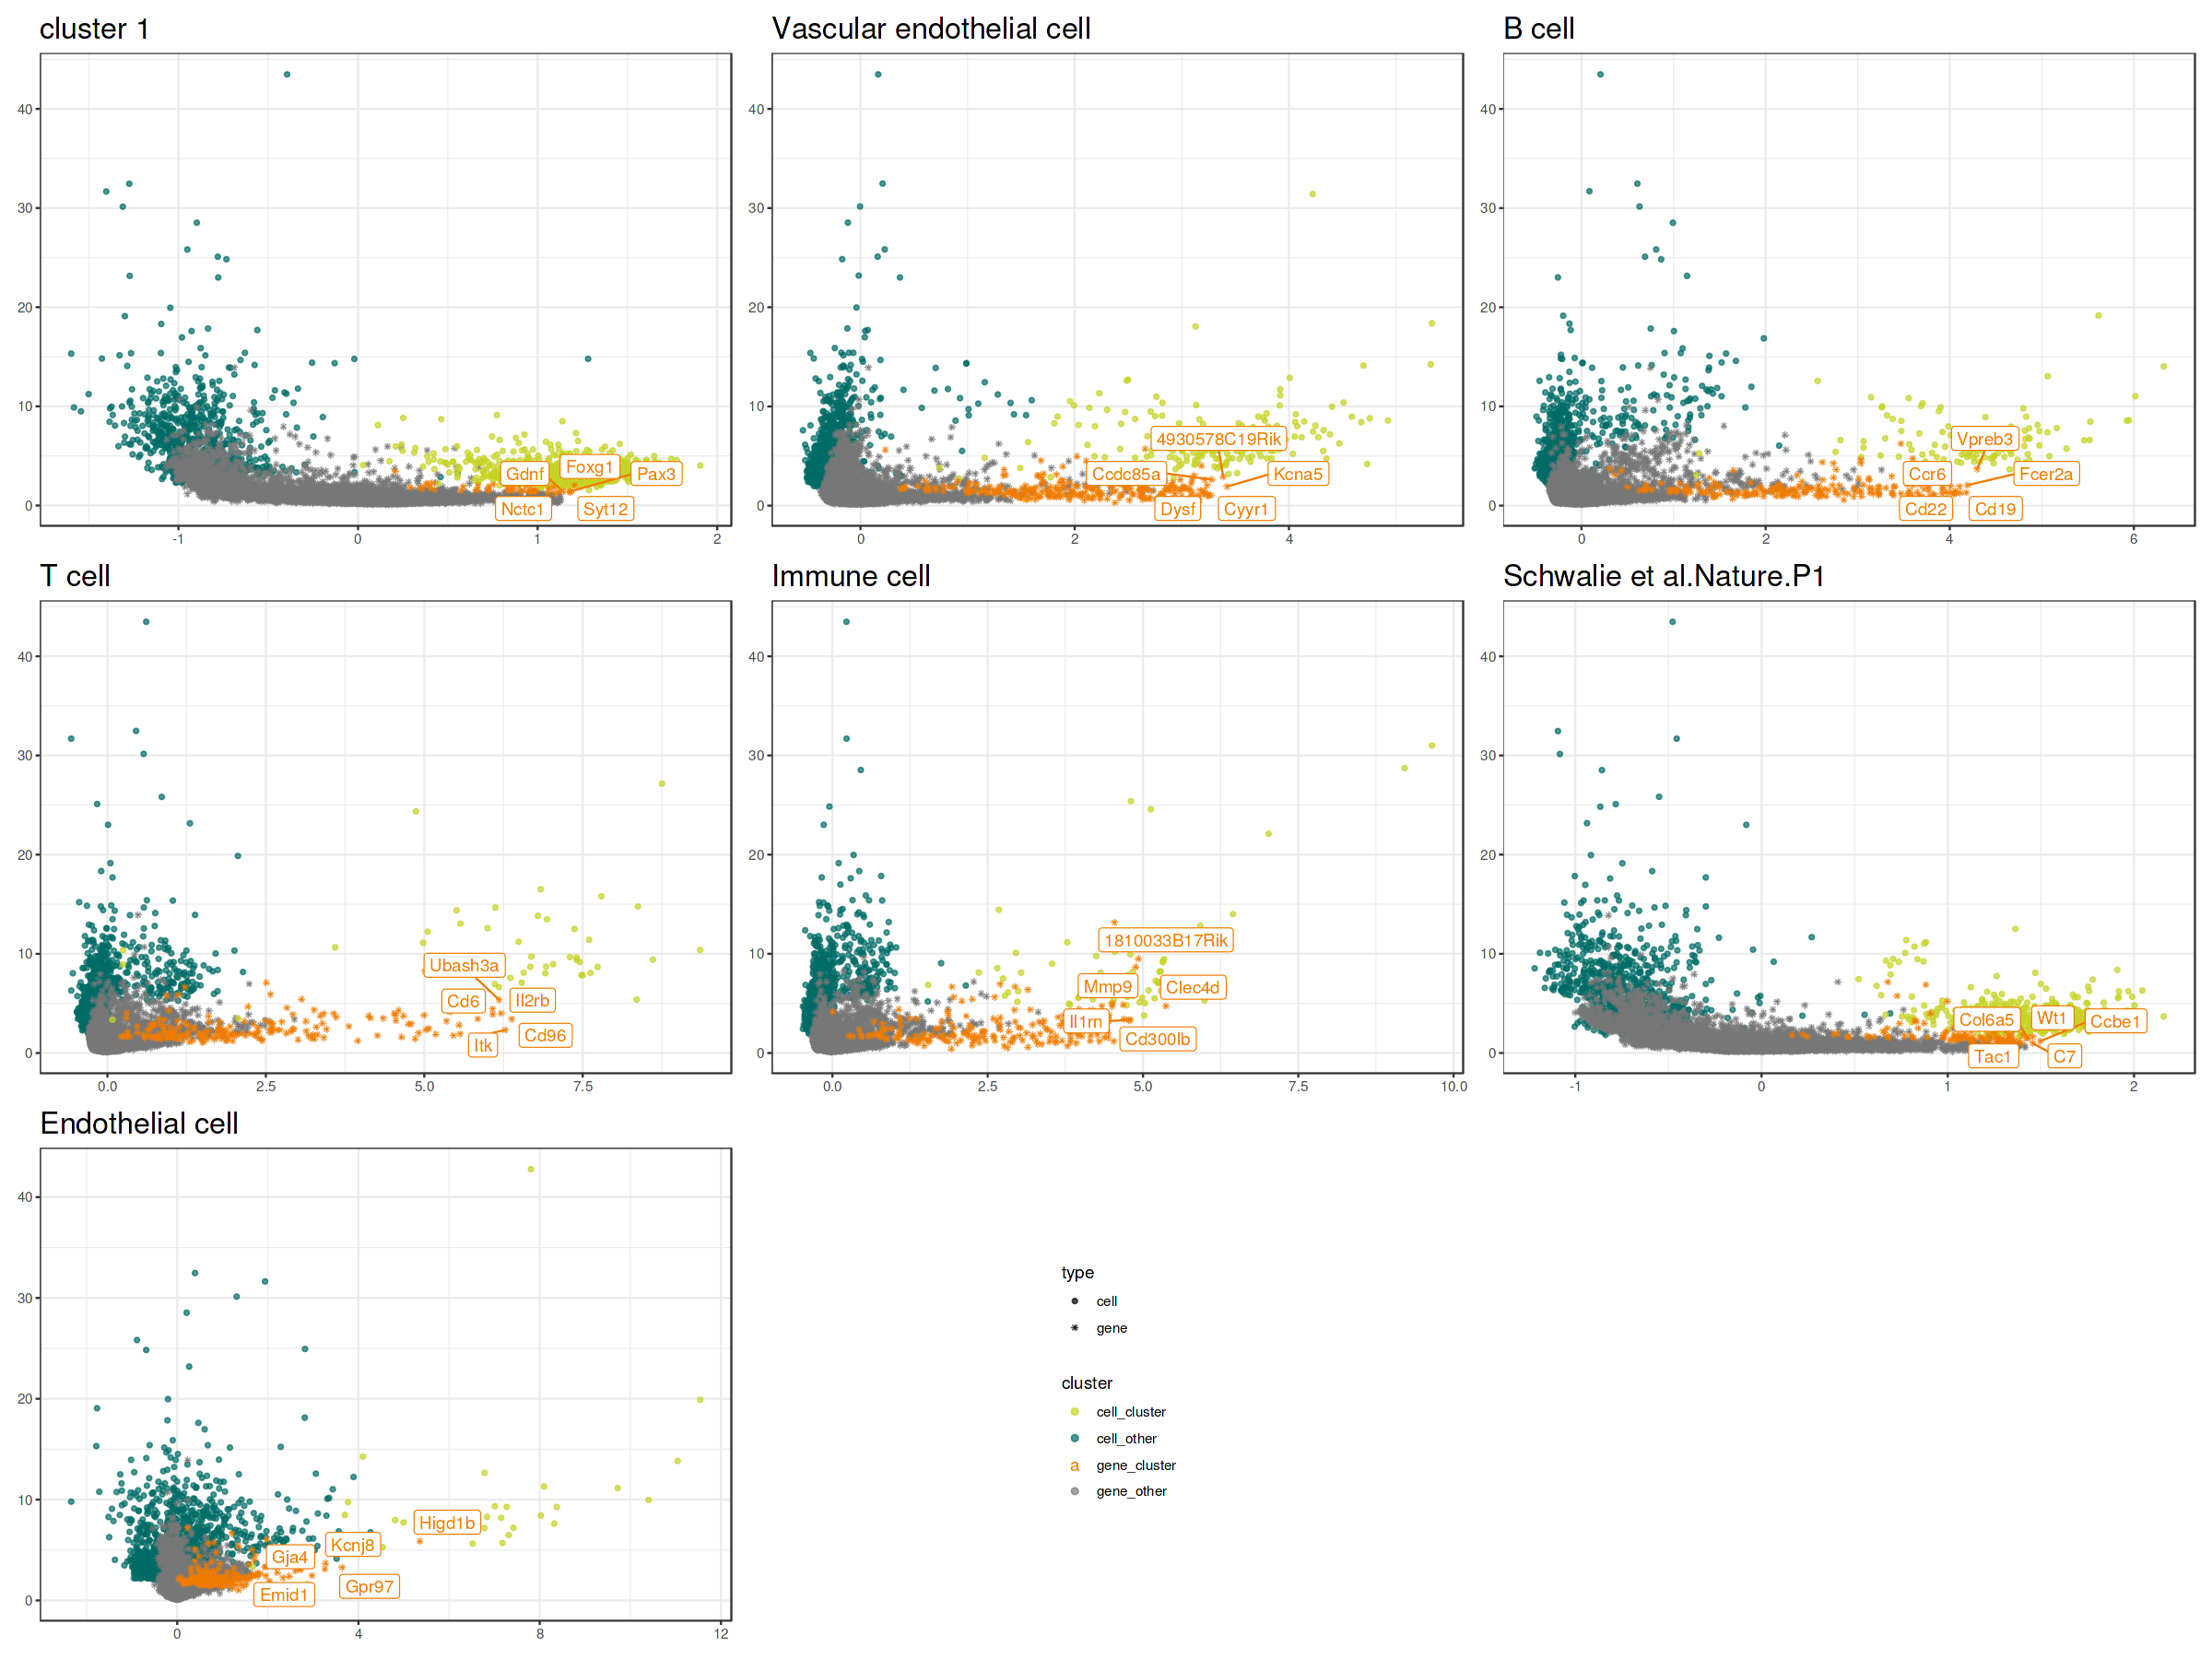

In [6]:
pcl <- plot_clusters(
  cadir = cak,
  caobj = ca,
  show_genes = TRUE,
  label_genes = TRUE,
  ntop = 5,
  title_prefix = "",
  axis = TRUE,
  text_size = 19,
  legend_pos = "right",
  return_list = TRUE,
  gsub_title = "_"
)
pcl <- wrap_plots(pcl, ncol = 3) +
  guide_area() +
  plot_layout(guides = "collect")

pcl

ggsave(
  plot = pcl,
  filename = file.path(imgdir, "cluster_apls.pdf"),
  device = cairo_pdf,
  width = 3400,
  height = 2000,
  units = "px"
)

ggsave(
  plot = pcl,
  filename = file.path(imgdir, "cluster_apls.png"),
  width = 3400,
  height = 2000,
  units = "px"
)

## B & T cells - standard coordinates APL

In [7]:
cls <- "B_cell"
group <- which(cak@cell_clusters == cls)
direction <- cak@directions[cak@dict[[cls]], ]

model <- apl_model(
  caobj = ca,
  direction = direction,
  group = group
)

tcs_coords <- model(ca@std_coords_cols)
tcs_coords <- tcs_coords[cak@cell_clusters == "T_cell", ]
t_dir <- cak@directions[cak@dict[["T_cell"]], ]
t_dir <- t_dir / ca@D  # prin_coords to std_coords
t_dir <- model(t_dir)

ics_coords <- model(ca@std_coords_cols)
ics_coords <- ics_coords[cak@cell_clusters == "Immune_cell", ]
i_dir <- cak@directions[cak@dict[["Immune_cell"]], ]
i_dir <- i_dir / ca@D  # prin_coords to std_coords
i_dir <- model(i_dir)

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


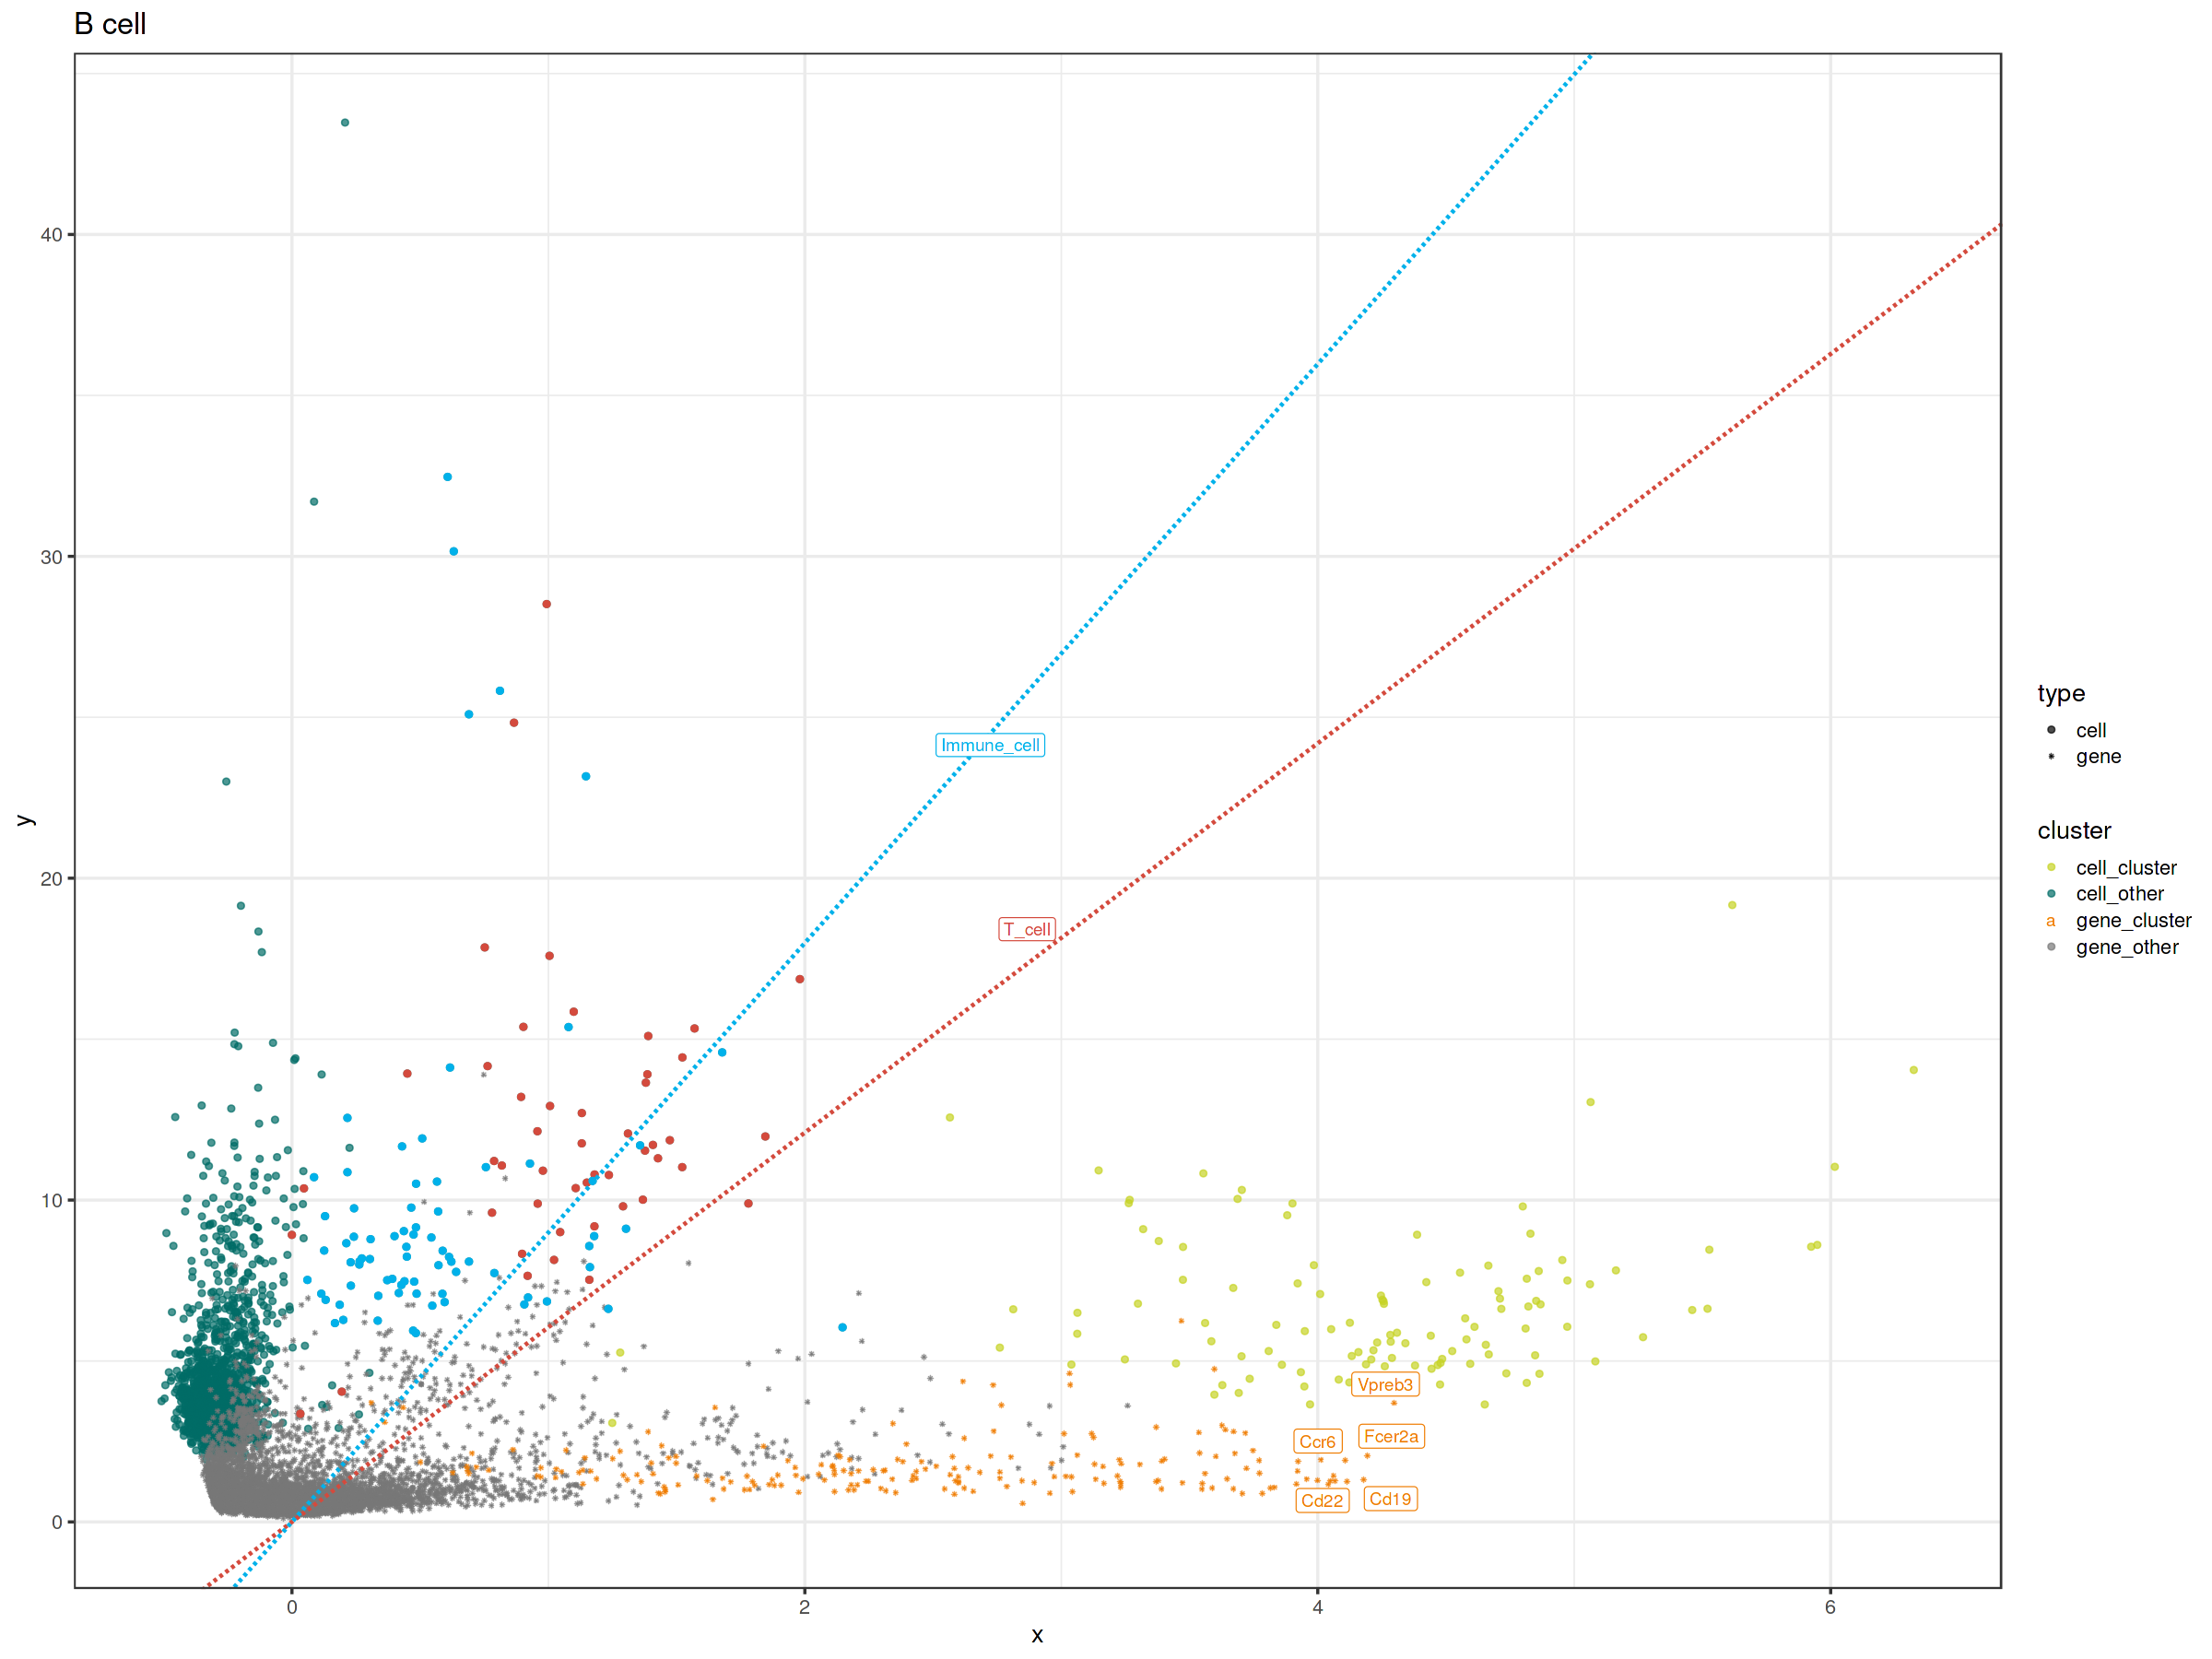

In [8]:
p_bt <- cluster_apl(
  ca,
  cak,
  cluster = cls,
  direction = cak@directions[cls, ],
  group = which(cak@cell_clusters == cls),
  highlight_cluster = TRUE,
  show_genes = TRUE,
  label_genes = TRUE,
  show_lines = FALSE,
  size_factor = 0.5,
  ntop = 5
) +
  geom_point(data = tcs_coords, aes(x=x, y=y), color = "#d44a3d" ) +
  ggplot2::geom_abline(
    intercept = 0,
    slope = slope(lines = t_dir, dims = 1:2),
    color = "#d44a3d",
    linetype = "dashed",
    size = 1) +
geom_label(data=as.data.frame(t_dir*4), aes(x, y), label="T_cell", color = "#d44a3d", vjust=-1) +
  geom_point(data = ics_coords, aes(x=x, y=y), color = "#00b1ea" ) +
  ggplot2::geom_abline(
    intercept = 0,
    slope = slope(lines = i_dir, dims = 1:2),
    color = "#00b1ea",
    linetype = "dashed",
    size = 1) +
geom_label(data=as.data.frame(i_dir*7), aes(x, y), label="Immune_cell", color = "#00b1ea", vjust=1) +
ggtitle("B cell") +
theme_bw(base_size = 16)

p_bt

ggsave(
  plot = p_bt,
  file = file.path(imgdir, "B_cell_cluster_std_coords.pdf"),
  device = cairo_pdf,
  width = 2000,
  height = 1600,
  units = "px"
)

## Endothelial cells - Standard coordinates APL

In [9]:
cls <- "Vascular_endothelial_cell"
group <- which(cak@cell_clusters == cls)
direction <- cak@directions[cak@dict[[cls]], ]

model <- apl_model(
  caobj = ca,
  direction = direction,
  group = group
)

ecs_coords <- model(ca@std_coords_cols)
ecs_coords <- ecs_coords[cak@cell_clusters == "Endothelial_cell", ]
e_dir <- cak@directions[cak@dict[["Endothelial_cell"]], ]
e_dir <- e_dir / ca@D  # prin_coords to std_coords
e_dir <- model(e_dir)

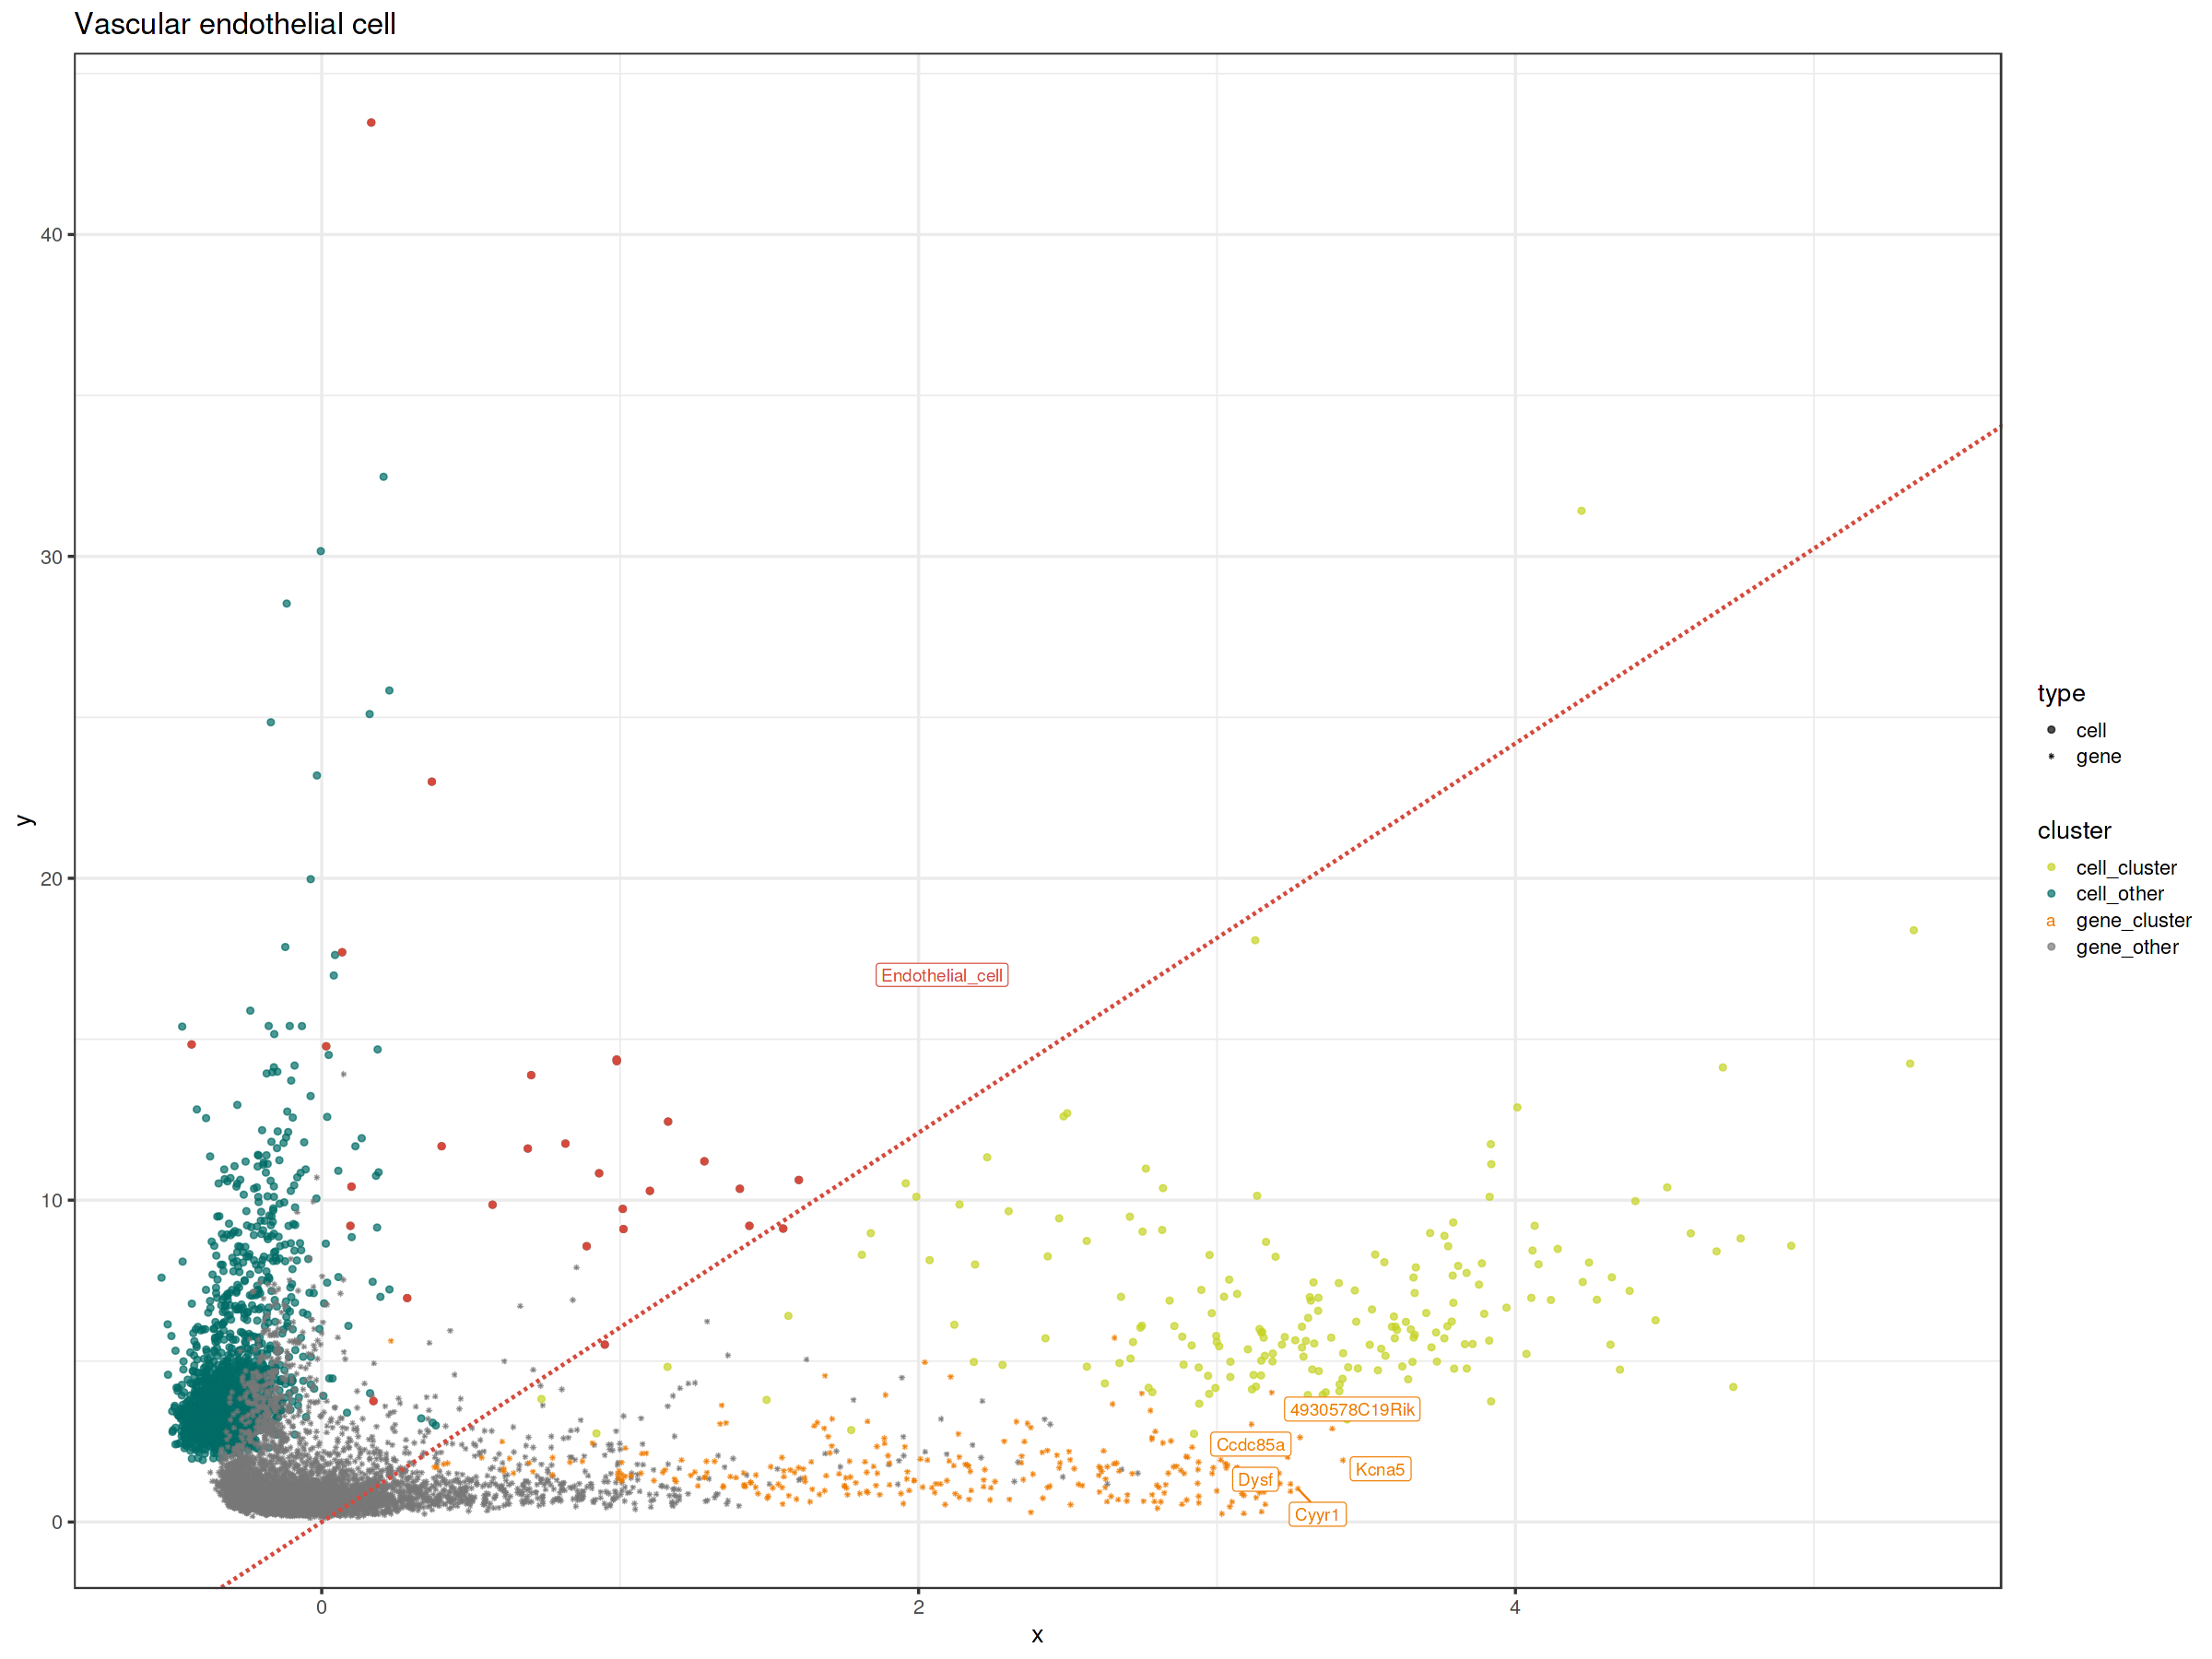

In [10]:
p_ecs <- cluster_apl(
  ca,
  cak,
  cluster = cls,
  direction = cak@directions[cls, ],
  group = which(cak@cell_clusters == cls),
  highlight_cluster = TRUE,
  show_genes = TRUE,
  label_genes = TRUE,
  show_lines = FALSE,
  size_factor = 0.5,
  ntop = 5
) +
  geom_point(data = ecs_coords, aes(x=x, y=y), color = "#d44a3d" ) +
  ggplot2::geom_abline(
    intercept = 0,
    slope = slope(lines = t_dir, dims = 1:2),
    color = "#d44a3d",
    linetype = "dashed",
    size = 1) +
geom_label(data=as.data.frame(e_dir*2), aes(x, y), label="Endothelial_cell", color = "#d44a3d", hjust=-0.5) +
  ggtitle("Vascular endothelial cell") +
theme_bw(base_size = 16)

p_ecs

ggsave(
  plot = p_ecs,
  file = file.path(imgdir, "endothelial_cell_clusters_std_coords.pdf"),
  device = cairo_pdf,
  width = 2000,
  height = 1600,
  units = "px"
)

## B & T cells - principal coordinates APL

In [11]:
cls <- "B_cell"
group <- which(cak@cell_clusters == cls)
direction <- cak@directions[cak@dict[[cls]], ]

model <- apl_model(
  caobj = ca,
  direction = direction,
  group = group
)

tcs_coords <- model(ca@prin_coords_cols)
tcs_coords <- tcs_coords[cak@cell_clusters == "T_cell", ]
t_dir <- cak@directions[cak@dict[["T_cell"]], ]
t_dir <- model(t_dir)

ics_coords <- model(ca@prin_coords_cols)
ics_coords <- ics_coords[cak@cell_clusters == "Immune_cell", ]
i_dir <- cak@directions[cak@dict[["Immune_cell"]], ]
i_dir <- model(i_dir)

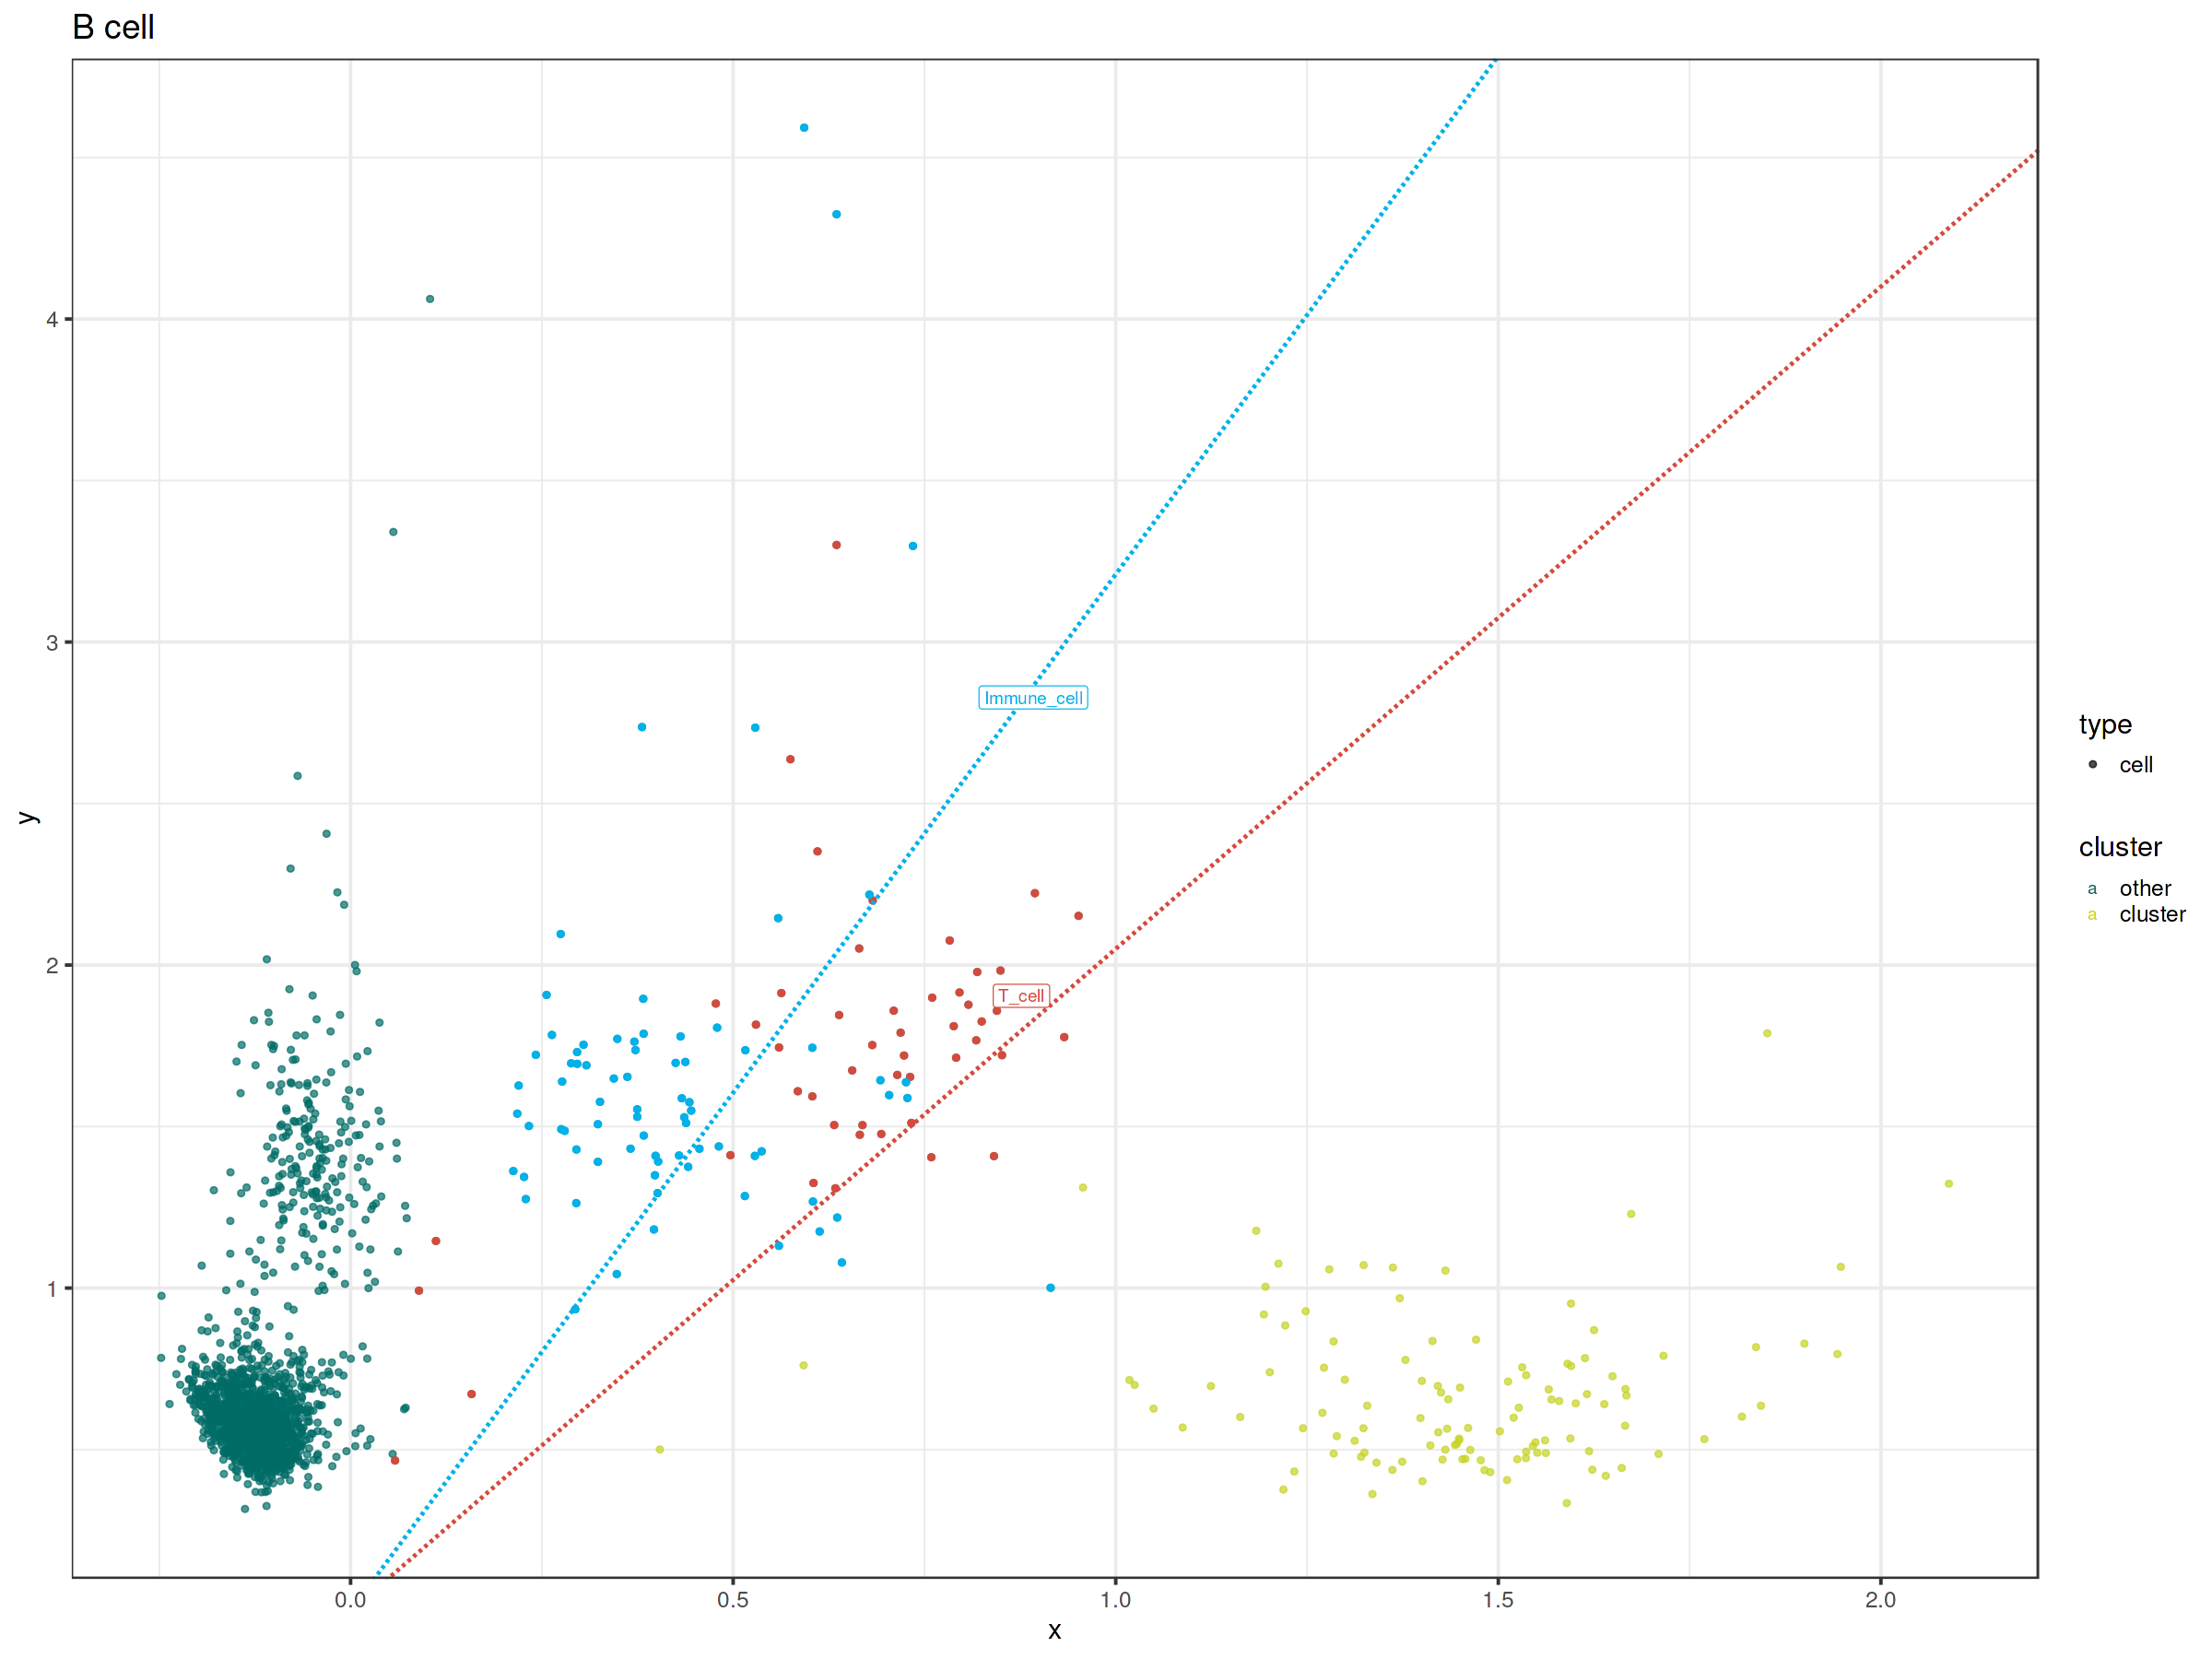

In [12]:
p_bt <- cluster_apl(
  ca,
  cak,
  cluster = cls,
  direction = cak@directions[cls, ],
  group = which(cak@cell_clusters == cls),
  highlight_cluster = TRUE,
  show_genes = FALSE,
  label_genes = TRUE,
  show_lines = FALSE,
  size_factor = 0.5,
  ntop = 5
) +
  geom_point(data = tcs_coords, aes(x=x, y=y), color = "#d44a3d" ) +
  ggplot2::geom_abline(
    intercept = 0,
    slope = slope(lines = t_dir, dims = 1:2),
    color = "#d44a3d",
    linetype = "dashed",
    size = 1) +
geom_label(data=as.data.frame(t_dir*2), aes(x, y), label="T_cell", color = "#d44a3d", vjust=-1) +
  geom_point(data = ics_coords, aes(x=x, y=y), color = "#00b1ea" ) +
  ggplot2::geom_abline(
    intercept = 0,
    slope = slope(lines = i_dir, dims = 1:2),
    color = "#00b1ea",
    linetype = "dashed",
    size = 1) +
  geom_label(data=as.data.frame(i_dir*3), aes(x, y), label="Immune_cell", color = "#00b1ea", vjust=1) +
  ggtitle("B cell") +
  theme_bw(base_size = 18) +
  theme(plot.title = element_text(size = 22))

p_bt

ggsave(
  plot = p_bt,
  file = file.path(imgdir, "B_cell_cluster_prin_coords.pdf"),
  device = cairo_pdf,
  width = 2000,
  height = 1600,
  units = "px"
)

## Endothelial cells - principal coordinates APL

In [13]:
cls <- "Vascular_endothelial_cell"
group <- which(cak@cell_clusters == cls)
direction <- cak@directions[cak@dict[[cls]], ]

model <- apl_model(
  caobj = ca,
  direction = direction,
  group = group
)

ecs_coords <- model(ca@prin_coords_cols)
ecs_coords <- ecs_coords[cak@cell_clusters == "Endothelial_cell", ]
e_dir <- cak@directions[cak@dict[["Endothelial_cell"]], ]
e_dir <- model(e_dir)

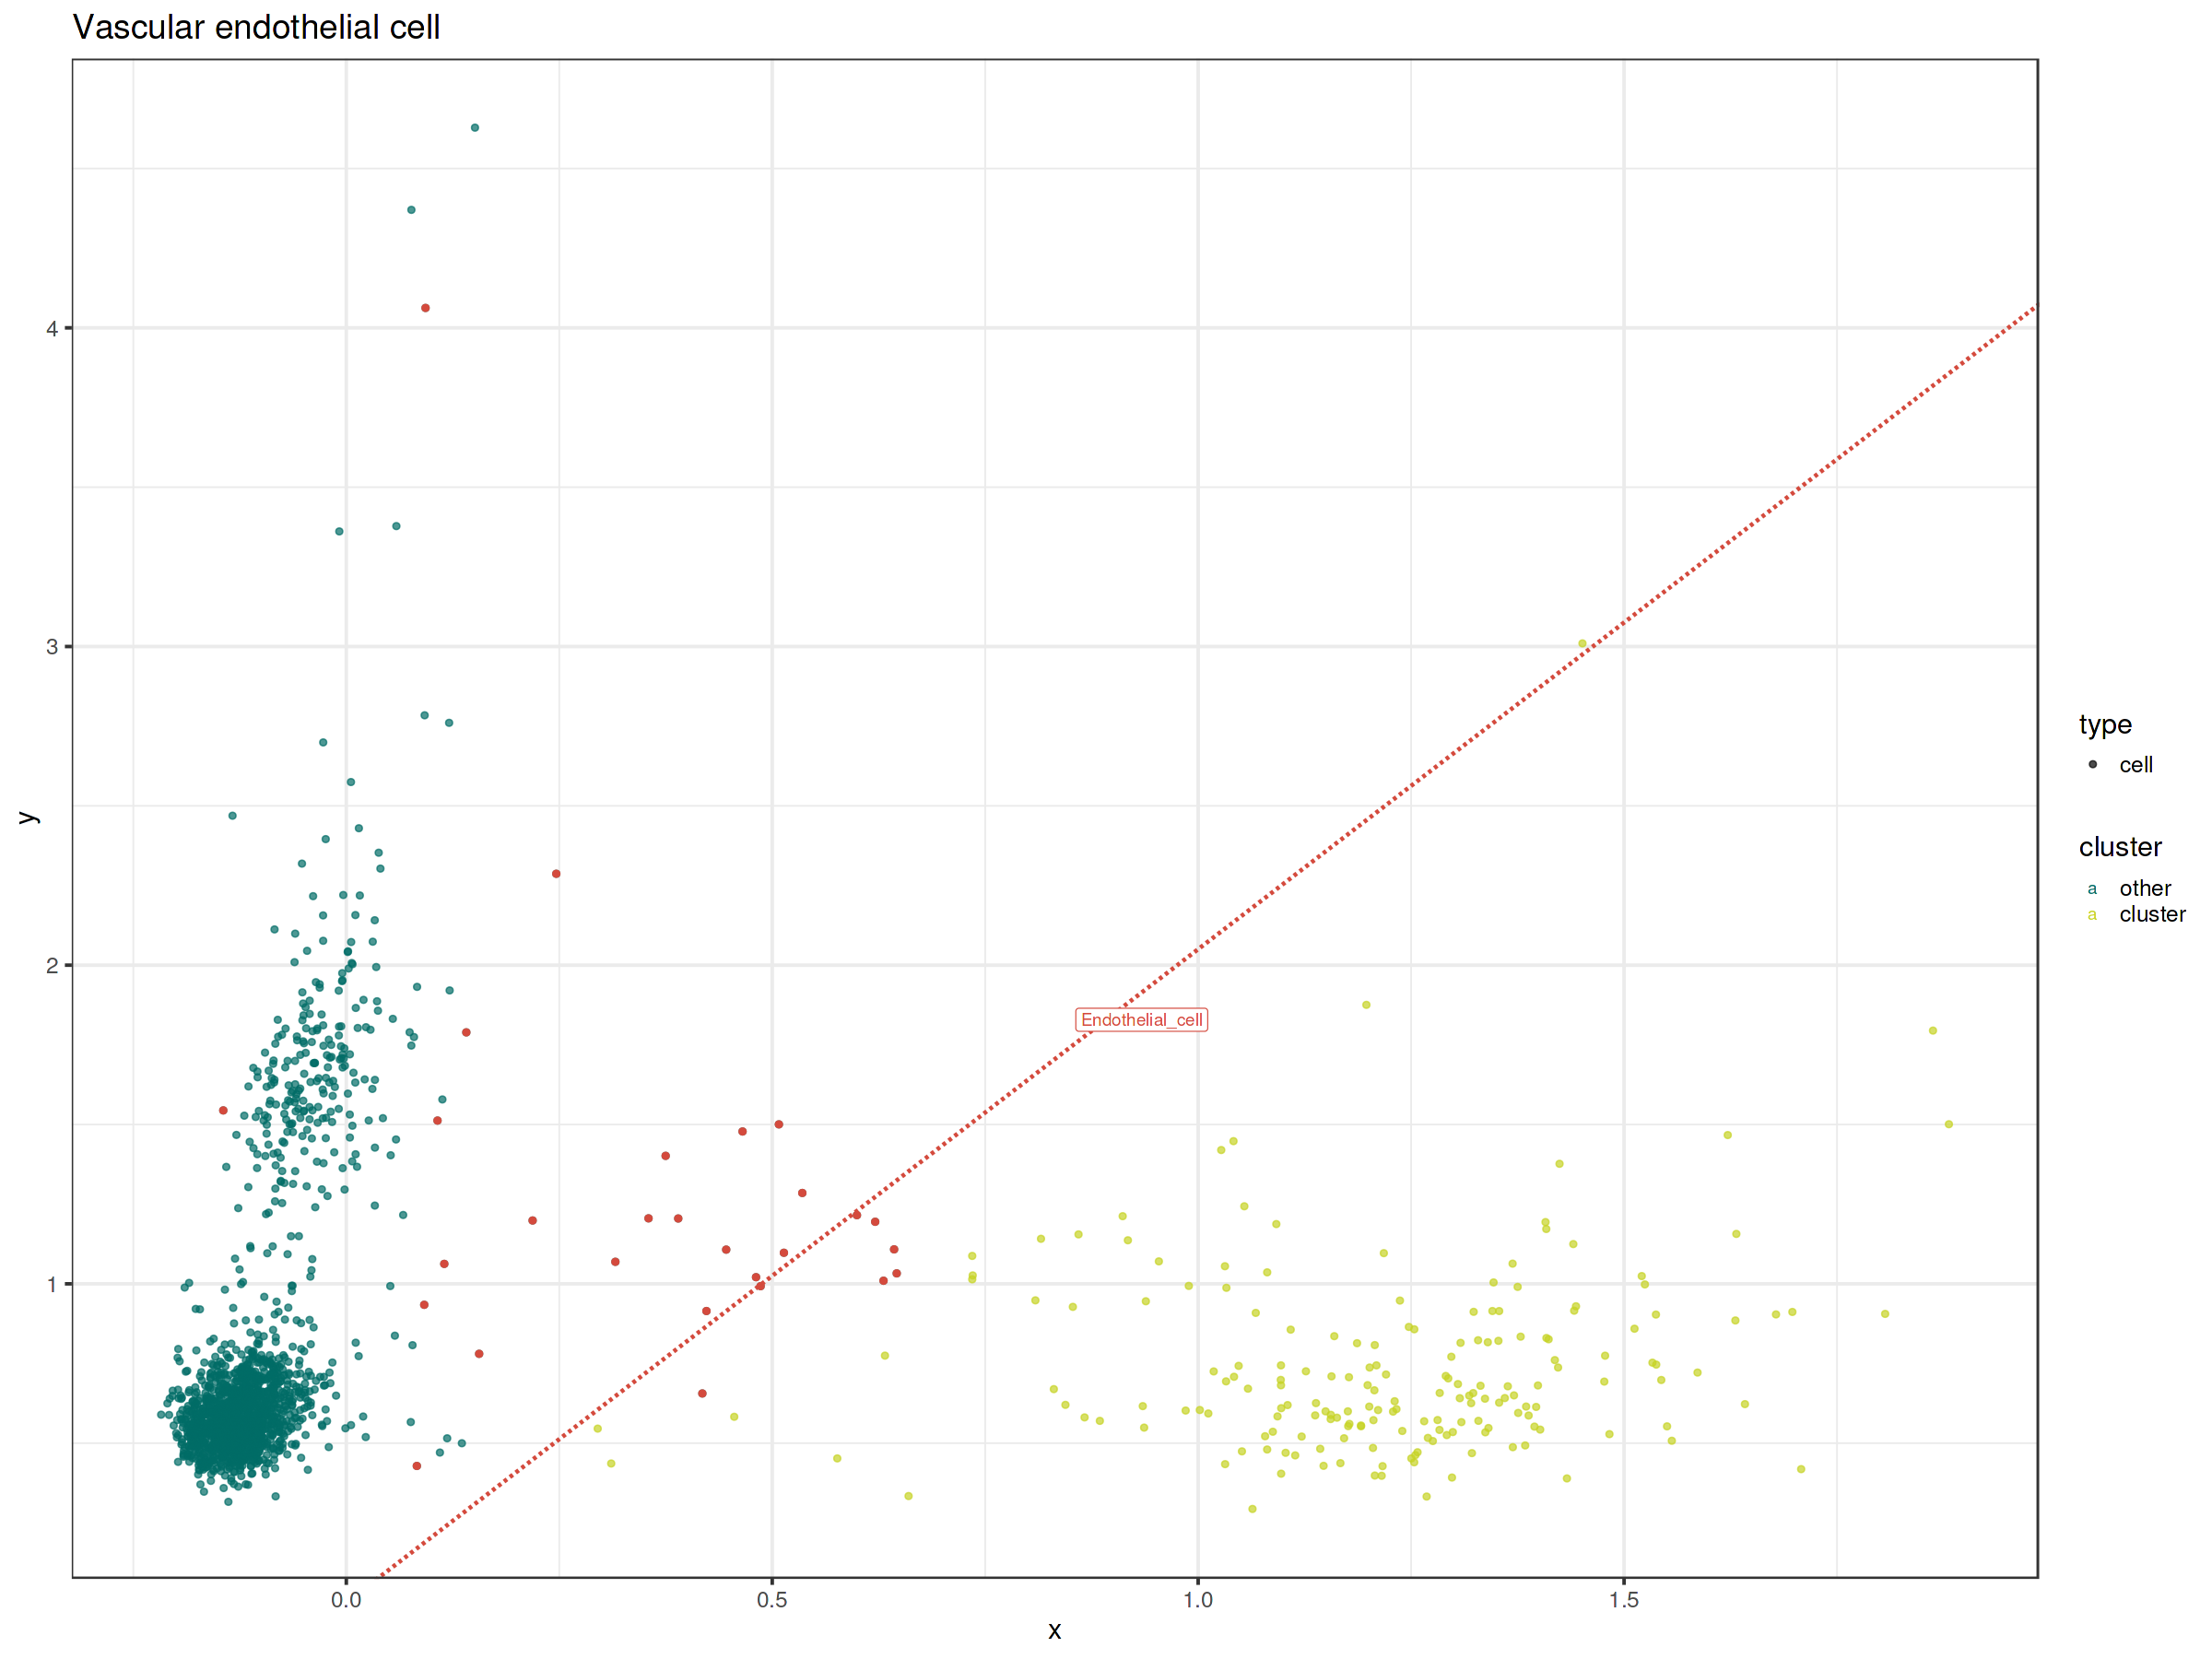

In [14]:
p_ecs <- cluster_apl(
  ca,
  cak,
  cluster = cls,
  direction = cak@directions[cls, ],
  group = which(cak@cell_clusters == cls),
  highlight_cluster = TRUE,
  show_genes = FALSE,
  label_genes = TRUE,
  show_lines = FALSE,
  size_factor = 0.5,
  ntop = 5
) +
  geom_point(data = ecs_coords, aes(x=x, y=y), color = "#d44a3d" ) +
  ggplot2::geom_abline(
    intercept = 0,
    slope = slope(lines = t_dir, dims = 1:2),
    color = "#d44a3d",
    linetype = "dashed",
    size = 1) +
geom_label(data=as.data.frame(e_dir*2), aes(x, y), label="Endothelial_cell", color = "#d44a3d", hjust=-0.3) +
  ggtitle("Vascular endothelial cell") +
  theme_bw(base_size = 18) +
  theme(plot.title = element_text(size = 22))

p_ecs

ggsave(
  plot = p_ecs,
  file = file.path(imgdir, "endothelial_cell_clusters_prin_coords.pdf"),
  device = cairo_pdf,
  width = 2000,
  height = 1600,
  units = "px"
)

# Further Plots
## SM plot

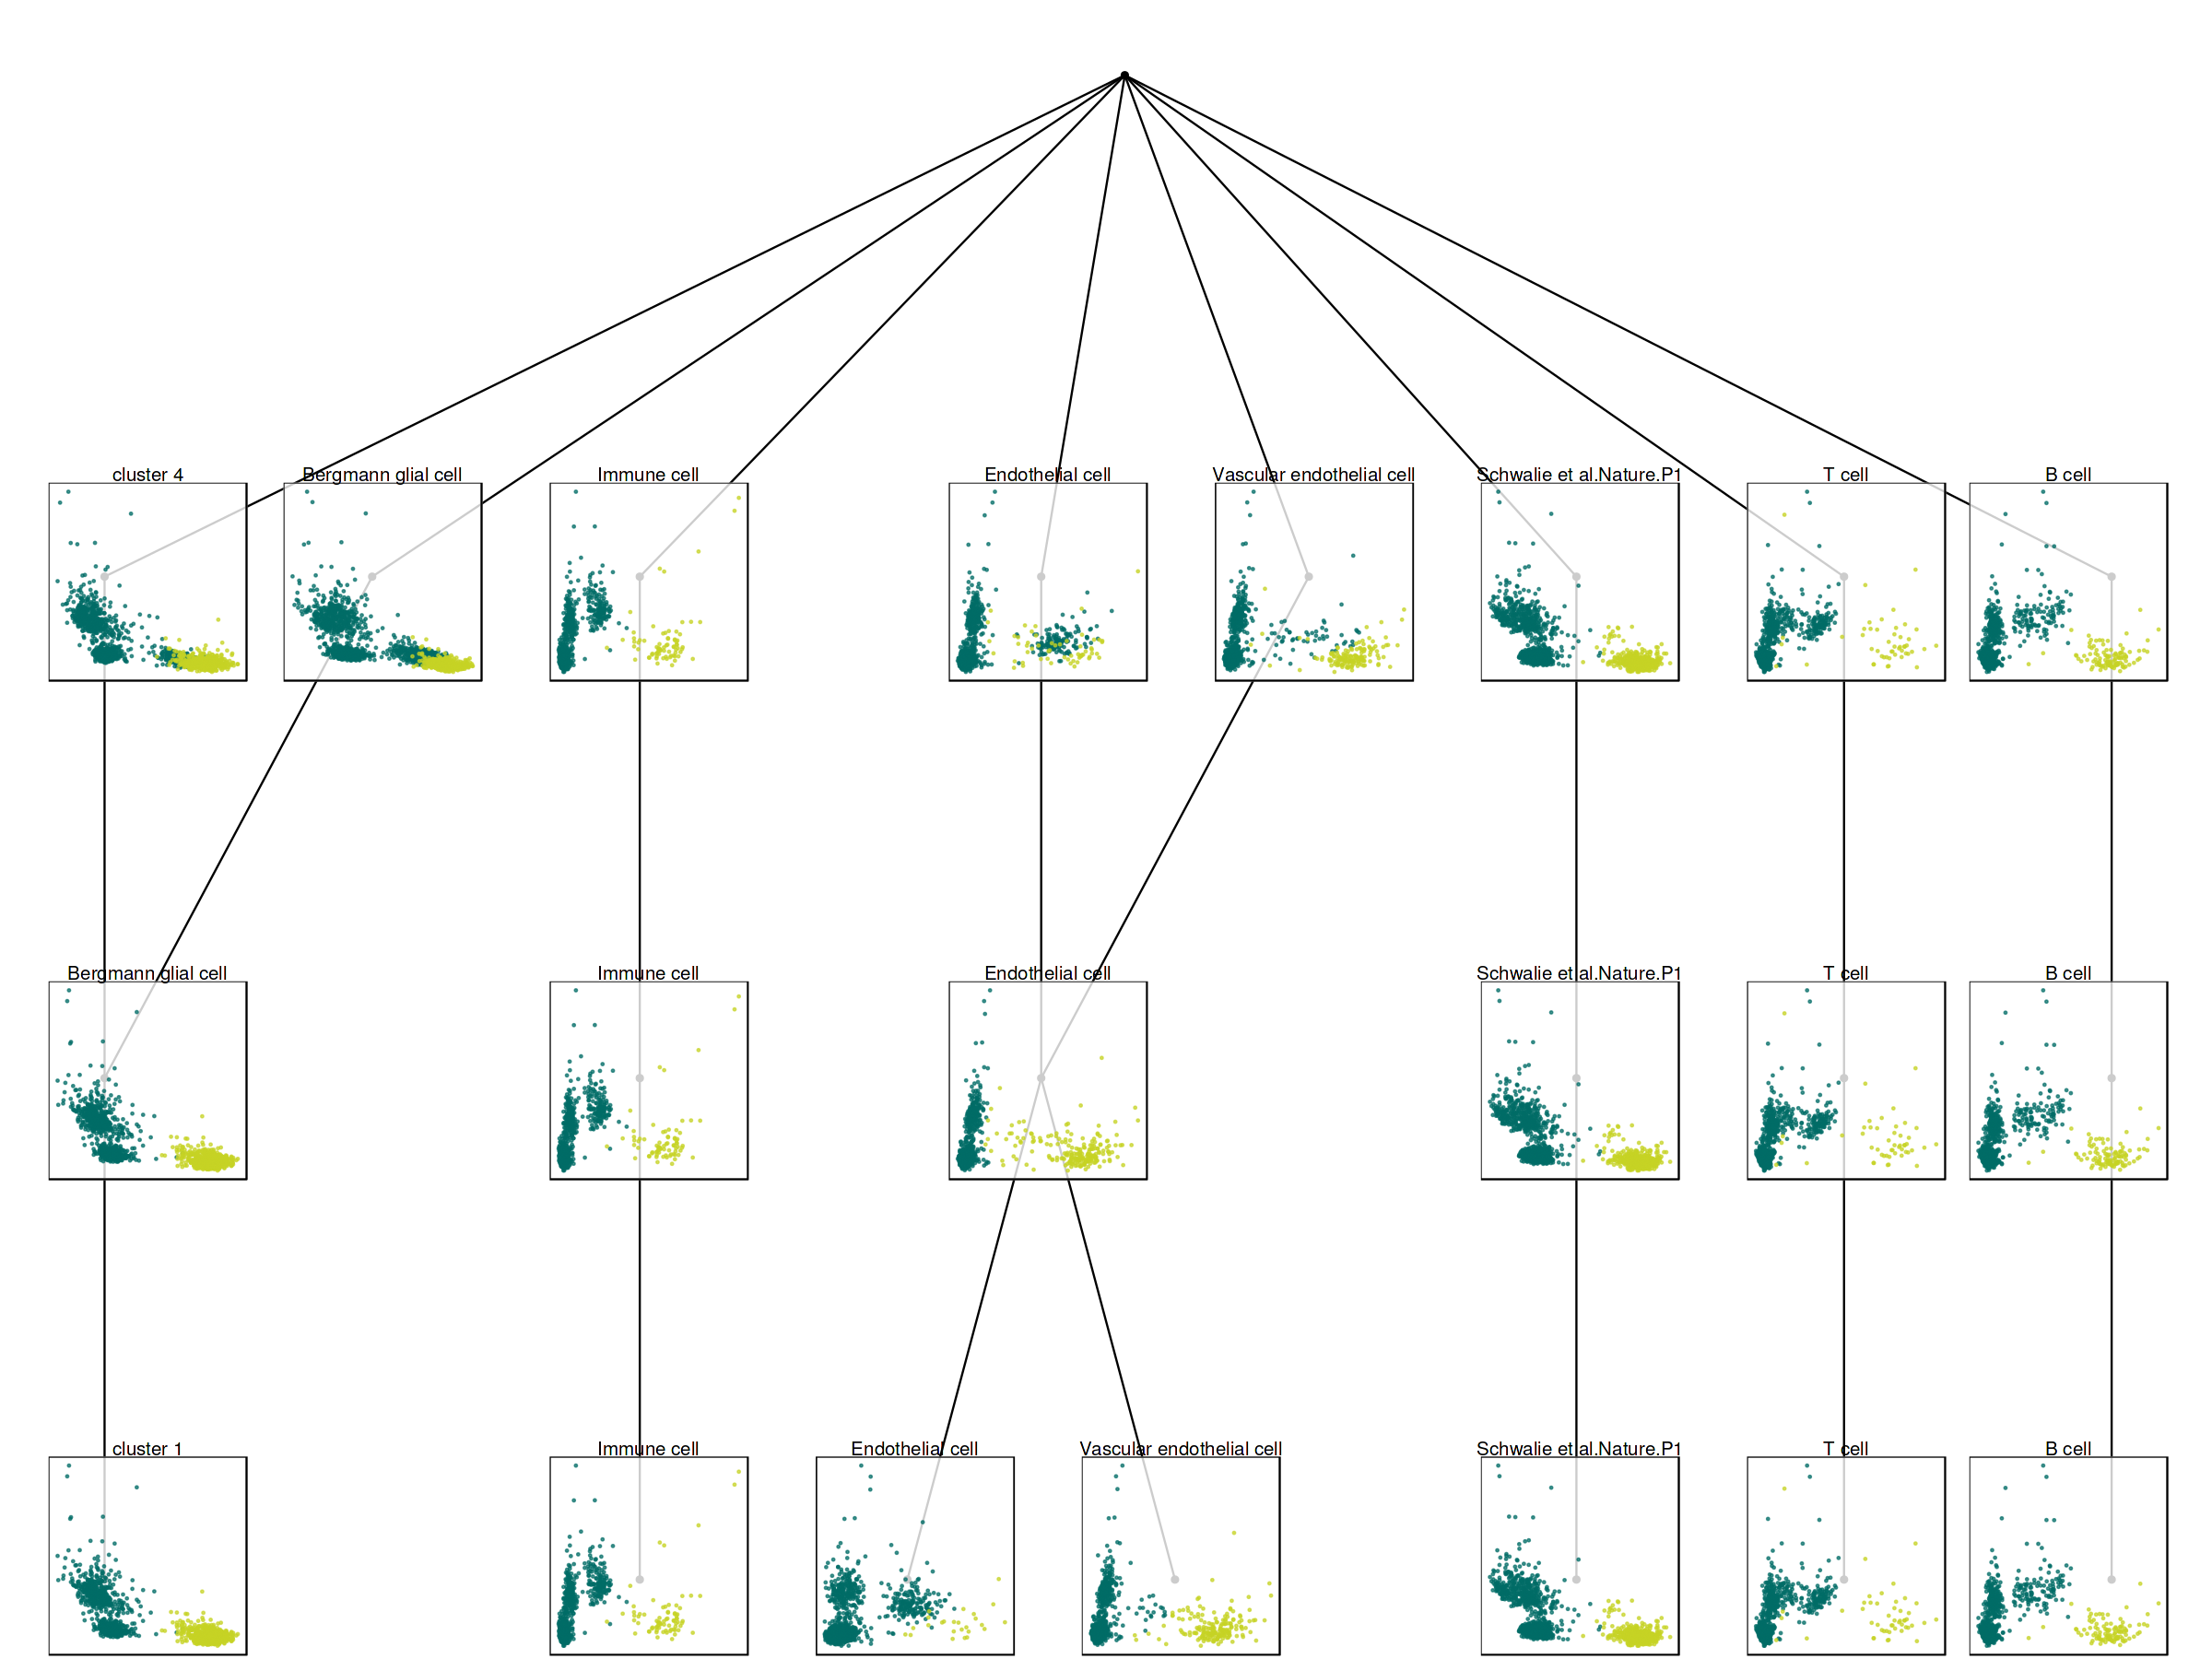

In [15]:
sm <- sm_plot(
  cadir = cak,
  caobj = ca,
  rm_redund = TRUE,
  keep_end = FALSE,
  highlight_cluster = TRUE,
  show_genes = F,
  annotate_clusters = TRUE,
  org = "mm",
  inlet_side = 0.13,
  title_size = 12,
  show_axis = FALSE
)

sm
ggsave(
  plot = sm,
  filename = file.path(imgdir,"tm_split_merge_plot.pdf"),
  device = cairo_pdf,
  width = 2300,
  height = 2100,
  units = "px"
)

ggsave(
  plot = sm,
  filename = file.path(imgdir,"tm_split_merge_plot.png"),
  width = 2300,
  height = 2100,
  units = "px"
)

## Sankey

Warning message:
“attributes are not identical across measure variables; they will be dropped”
`summarise()` has grouped output by 'Biclusters'. You can override using the `.groups` argument.


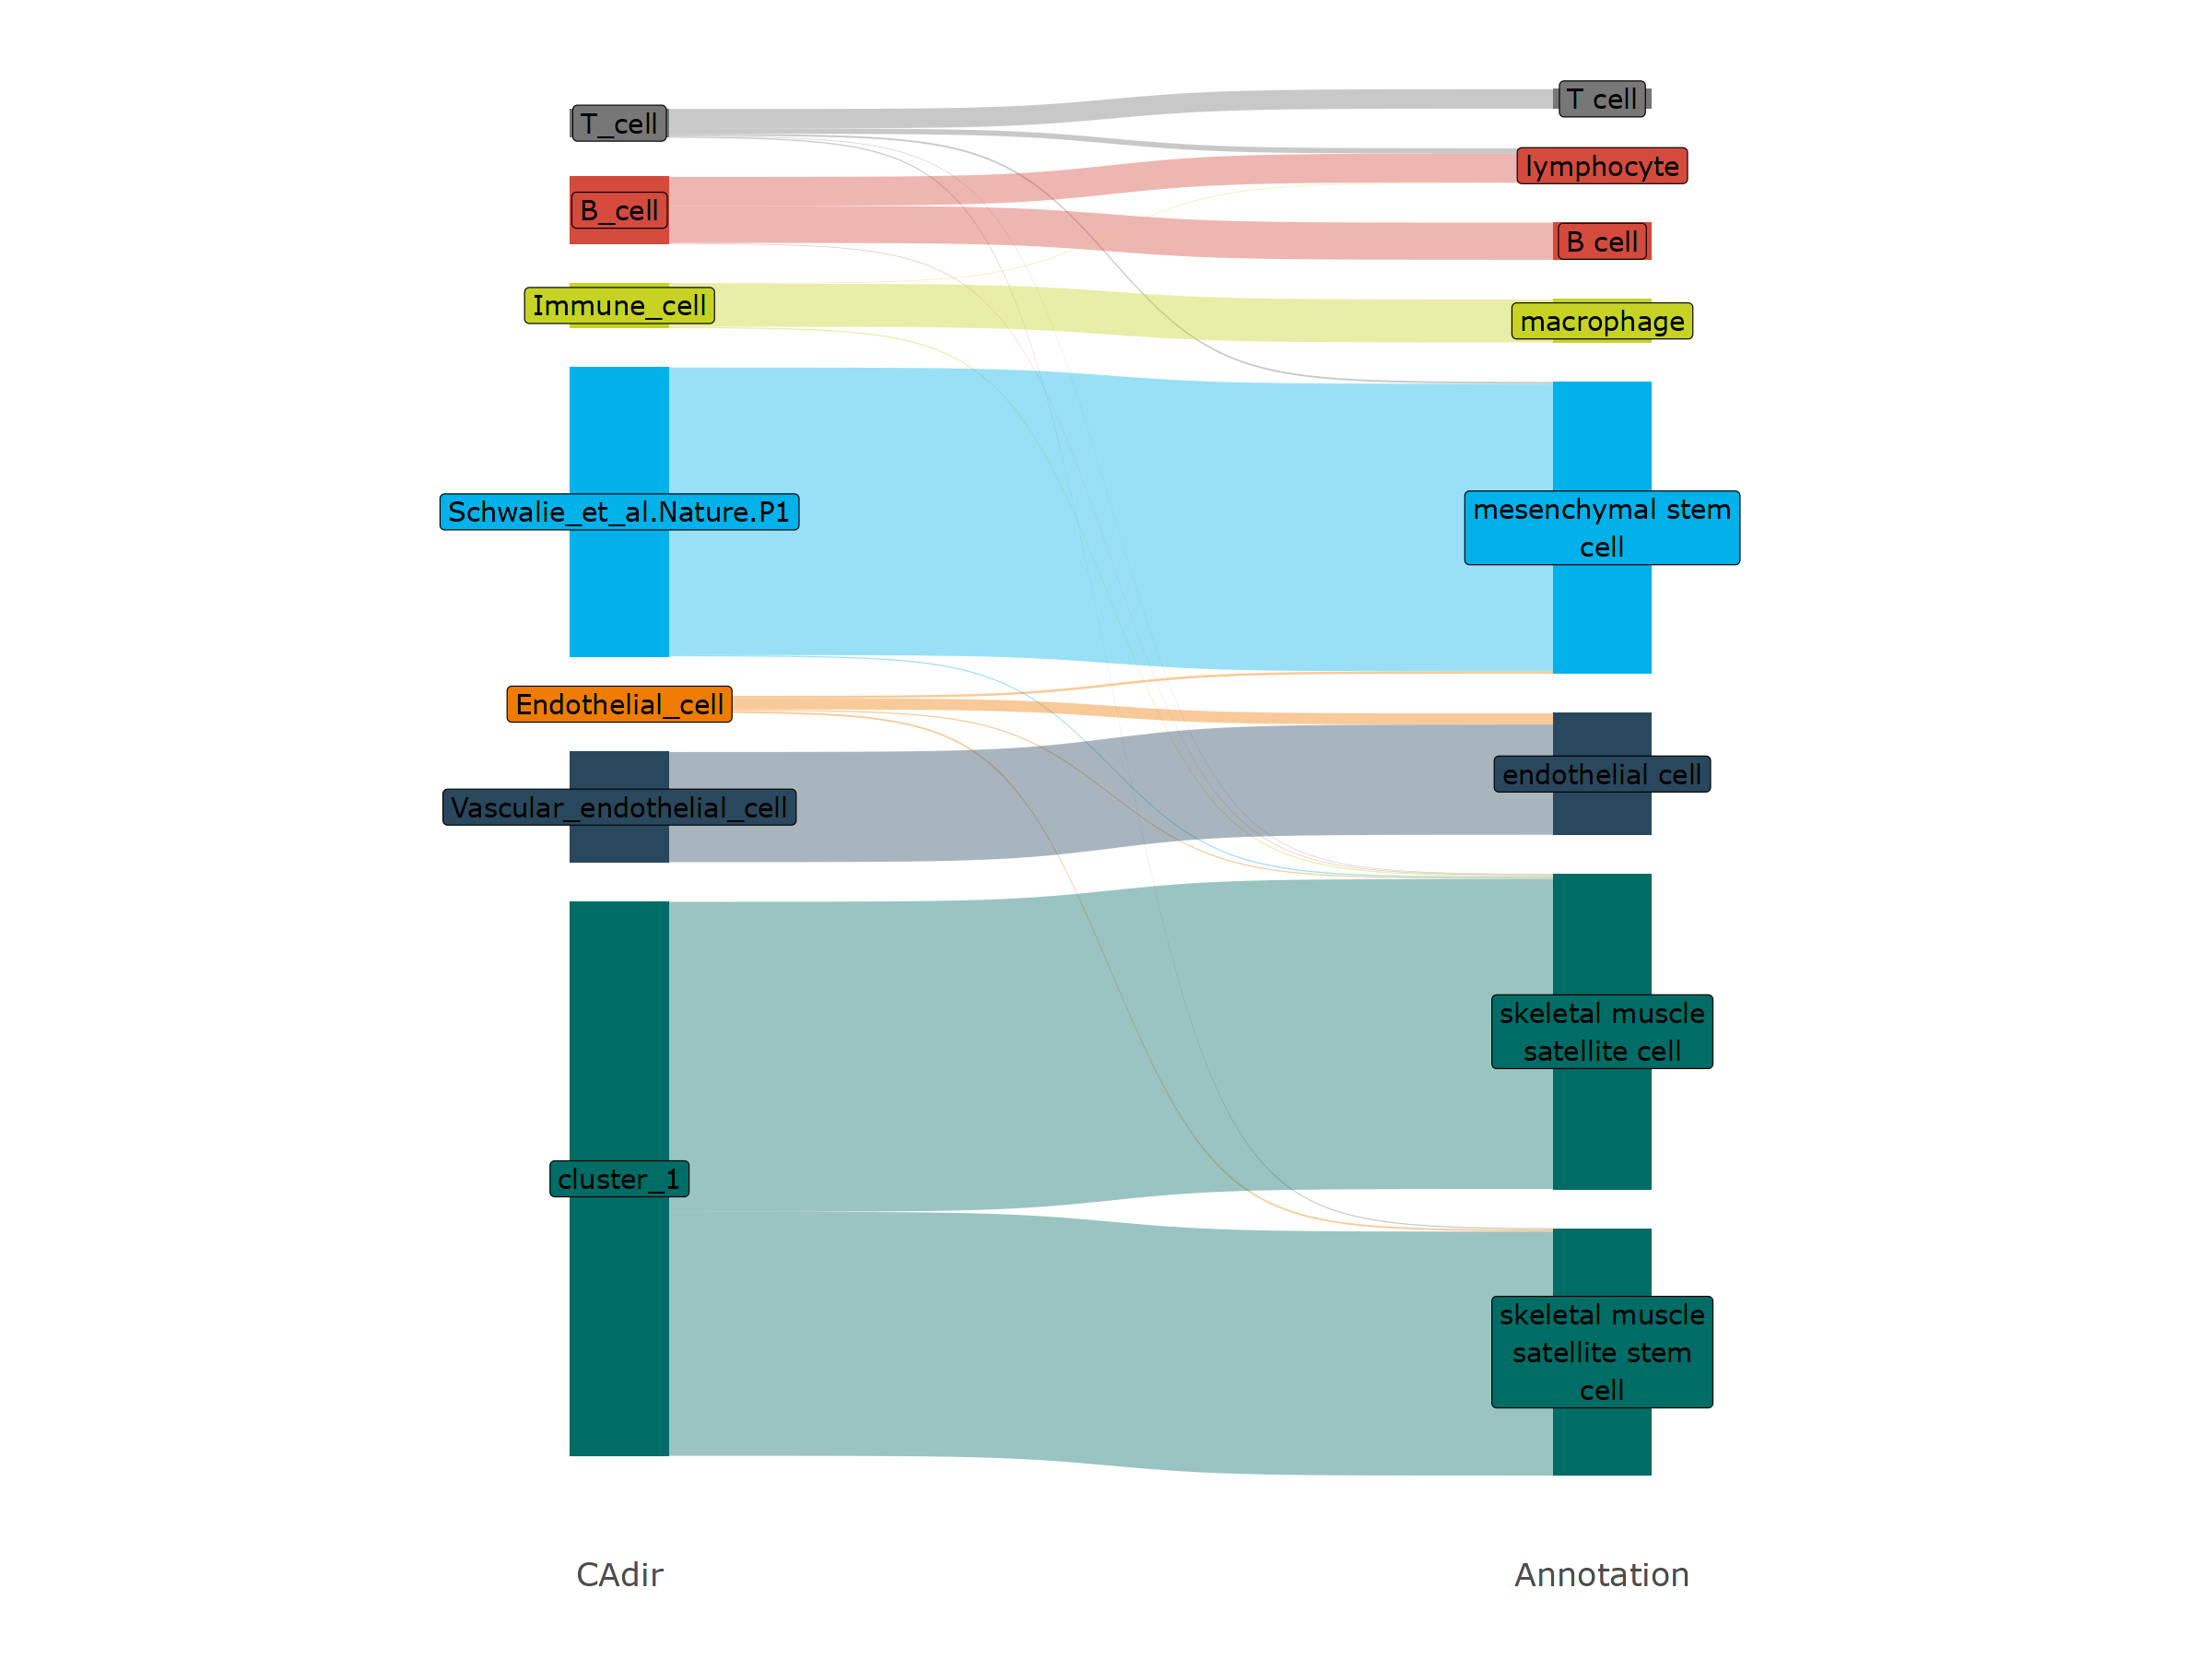

In [16]:
library(ggsankey)
sce_sank <- sce_sub

data <- colData(sce_sank) %>%
        as.data.frame() %>%
        rename('CAdir' = "cadir",
               'Annotation' = "cell_ontology_class")

df <- data %>%
    make_long(CAdir, Annotation)

info  <-  data.frame(Biclusters = as.factor(data$CAdir),
                     Truth = as.character(data$Annotation)) %>%
                as_tibble() %>%
                group_by(Biclusters, Truth) %>%
                summarise(n = n()) %>%
                group_by(Truth) %>%
                mutate(Partition = n/sum(n)) %>%
                ungroup() %>%
                as.data.frame() %>%
                group_by(Truth) %>%
                filter(Partition == max(Partition) ) %>%
                dplyr::select(Biclusters, Truth) %>%
                distinct(Biclusters, .keep_all = TRUE)


pal <- mpi_extend_pal()

cols <- pal(length(unique(sce_sank$cadir)))
names(cols) <- unique(sce_sank$cadir)

info <- left_join(data.frame("Biclusters" = names(cols), "col" = cols), info, by = "Biclusters")

cols <- c(cols, info$col)

names(cols) <- c(as.character(unique(sce_sank$cadir)), info$Truth)

order <- c(
  "cluster_1",
  "Vascular_endothelial_cell",
  "Endothelial_cell",
  "Schwalie_et_al.Nature.P1",
  "Immune_cell",
  "B_cell",
  "T_cell",

  "skeletal muscle satellite stem cell",
  "skeletal muscle satellite cell",
  "endothelial cell",
  "mesenchymal stem cell",
  "macrophage",
  "B cell",
  "lymphocyte",
  "T cell"
)

wrap <- 17
df$node <- factor(stringr::str_wrap(df$node, wrap), levels = stringr::str_wrap(order, wrap))
df$next_node <- factor(stringr::str_wrap(df$next_node, wrap), levels = stringr::str_wrap(order, wrap))

names(cols) <- stringr::str_wrap(names(cols), wrap)


sank <- ggplot(df, aes(x = x,
               next_x = next_x,
               node = node,
               next_node = next_node,
               fill = node,
               label = as.character(node))) +
  geom_sankey(
    flow.alpha = 0.4,
  ) +
  geom_sankey_label(size = 6) +
  labs(x = "") +
  scale_fill_manual(values = cols) +
  theme_sankey(base_size = 26, base_family = "sans") +
  theme(
    legend.position = "none"
  )

sank

ggsave(plot = sank,
       filename = file.path(imgdir, "sankey_plot_TM_clustering.pdf"),
       width = 2700,
       height = 2400,
       device = cairo_pdf,
       units = "px")

ggsave(plot = sank,
       filename = file.path(imgdir, "sankey_plot_TM_clustering.png"),
       width = 2700,
       height = 2400,
       units = "px")

## Angle between clusters

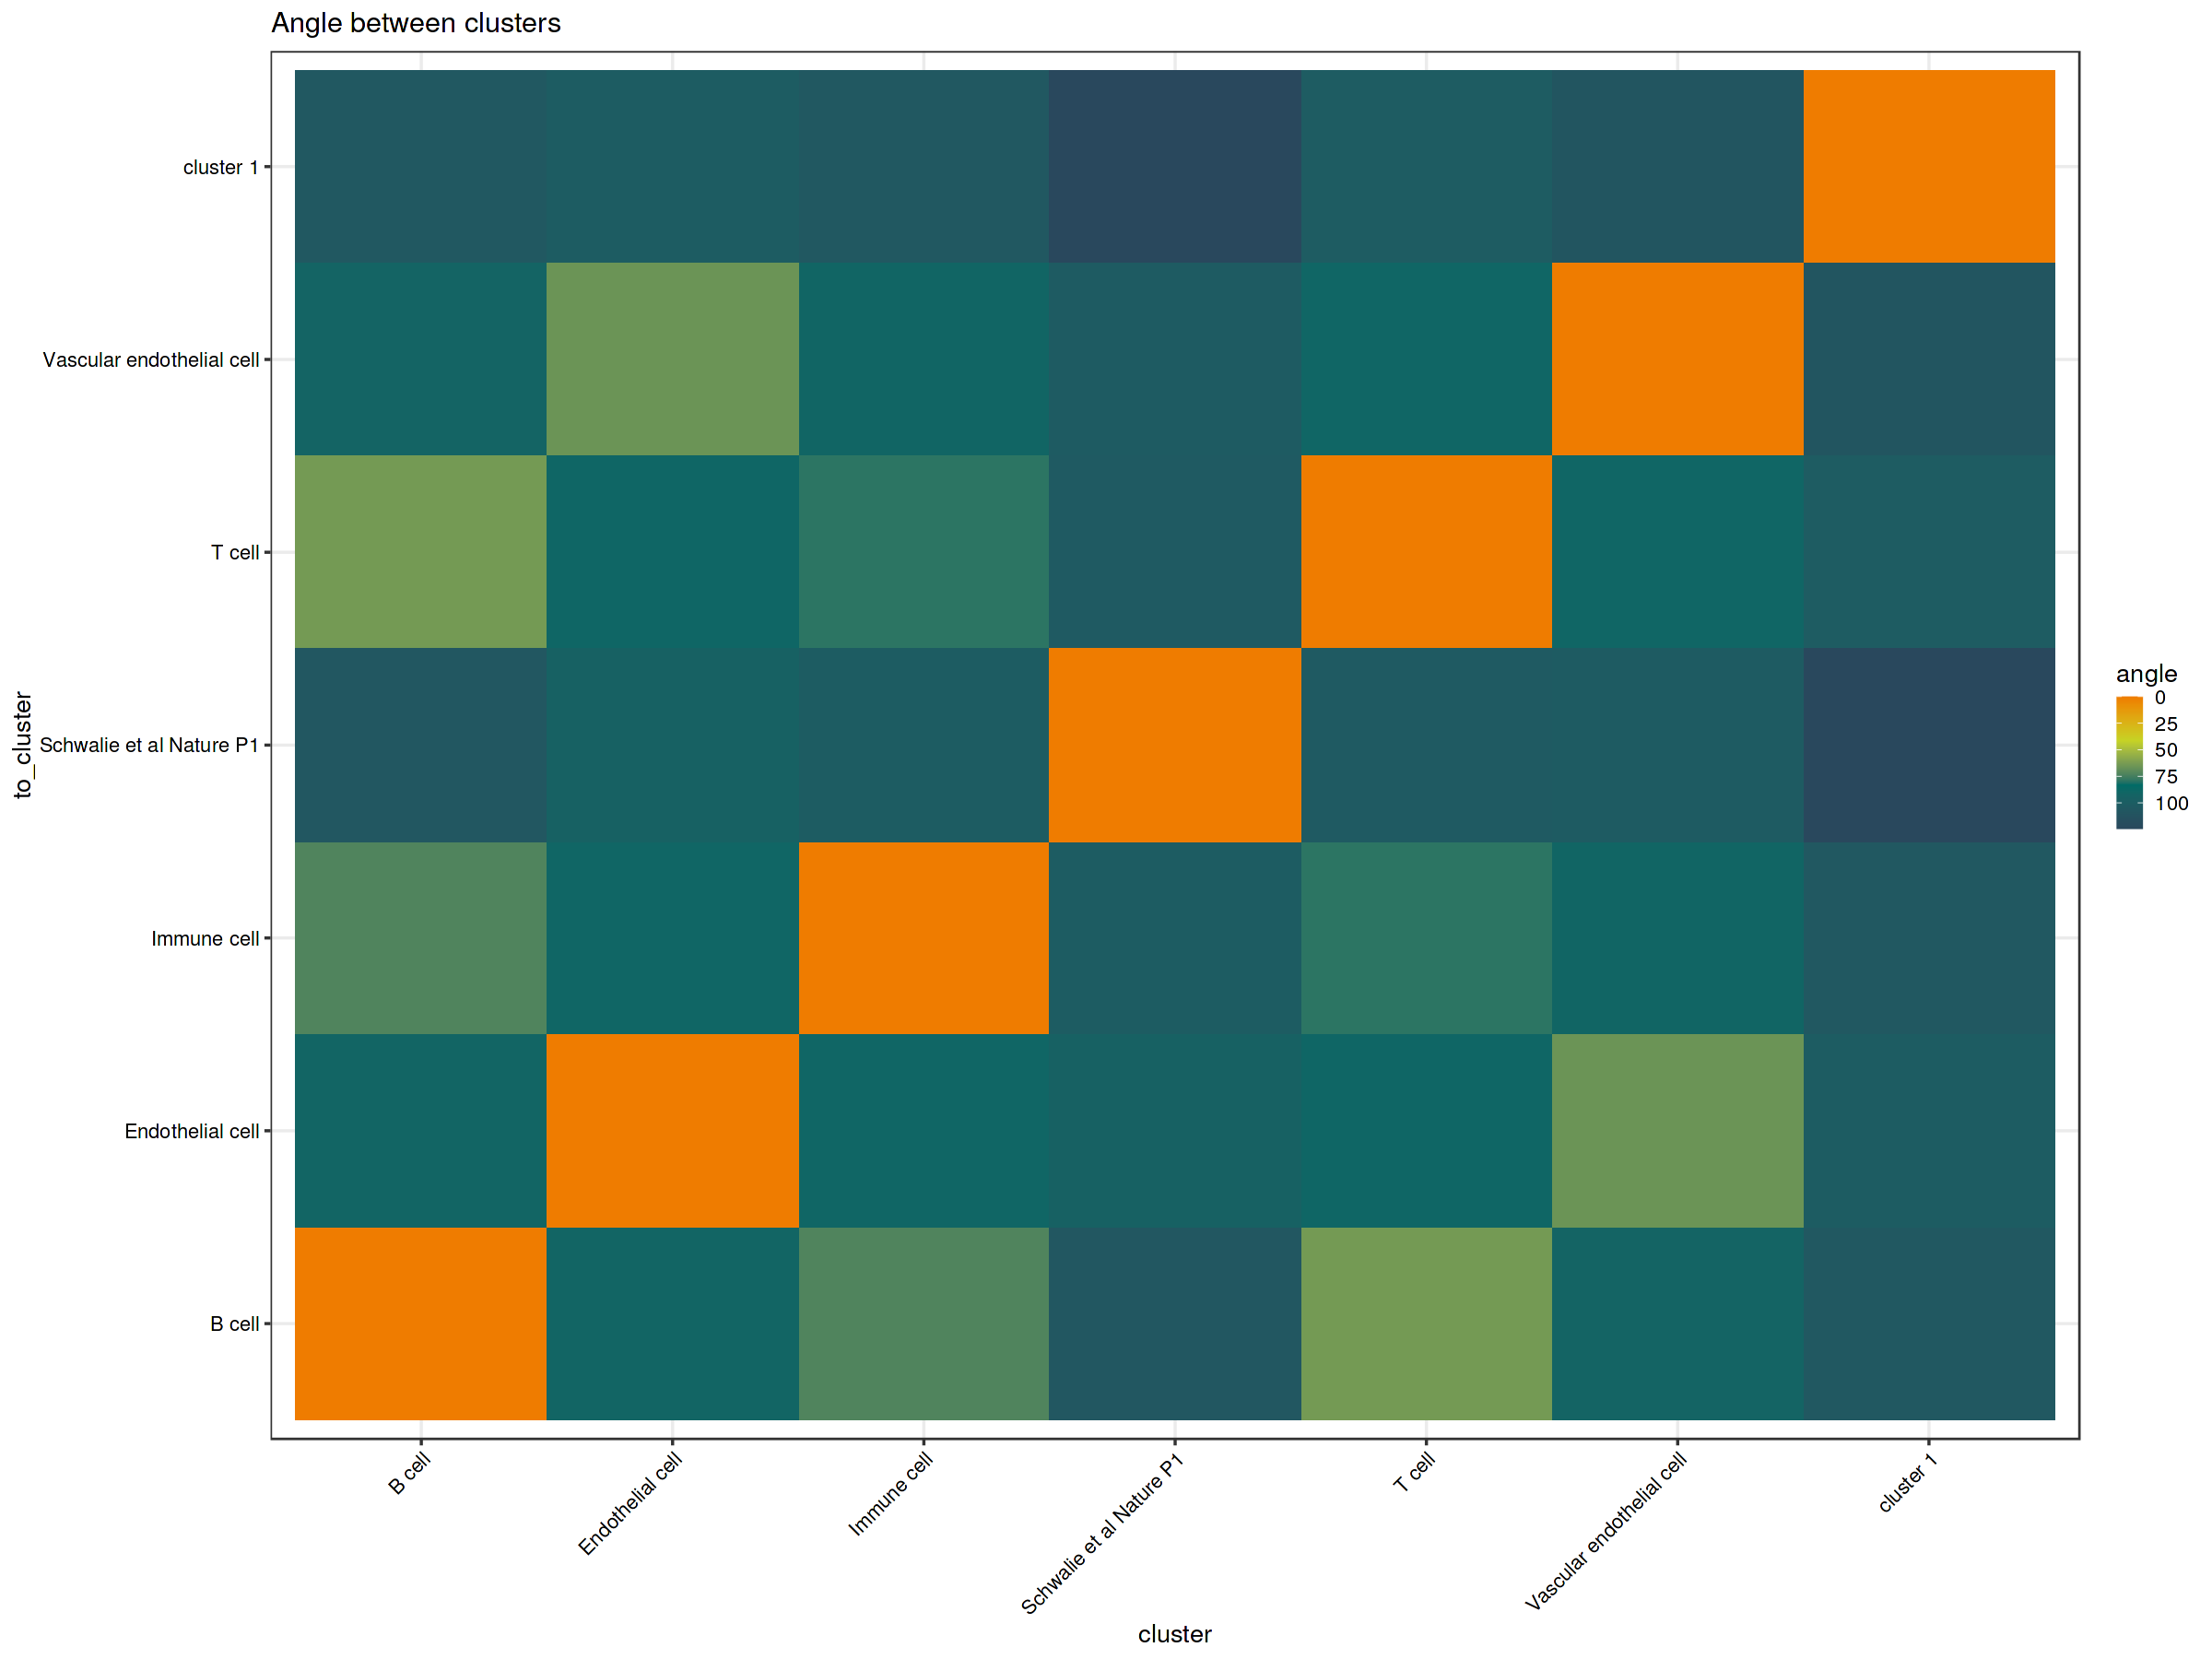

In [17]:
ang_rad <- get_angle(cak@directions, cak@directions)
rownames(ang_rad) <- gsub("_|\\.", " ", rownames(ang_rad))
colnames(ang_rad) <- gsub("_|\\.", " ", colnames(ang_rad))
ang_deg <- as.data.frame(rad2deg(ang_rad)) %>% tibble::rownames_to_column("cluster")

long_ang <- tidyr::pivot_longer(data = ang_deg, cols = -cluster, values_to = "angle", names_to = "to_cluster" )

p <- ggplot(long_ang, aes(x=cluster, y = to_cluster, fill = angle)) +
  geom_tile() +
  scale_fill_gradient_mpimg(name = "orange", trans = "reverse") +
  theme_bw(base_size = 16)+
theme(
    axis.text.x = element_text(color = "black", angle = 45, vjust = 1, hjust=1),
    axis.text.y = element_text(color = "black"),
    plot.title = element_text(size = 18)
  ) +
  ggtitle("Angle between clusters")

p

ggsave(
  plot = p,
  filename = file.path(imgdir, "angle_between_clusters.pdf"),
  width = 2000,
  height = 1600,
  units = "px"
)

Warning message:
“No shared levels found between `names(values)` of the manual scale and the data's size values.”
Warning message:
“No shared levels found between `names(values)` of the manual scale and the data's size values.”
Warning message:
“No shared levels found between `names(values)` of the manual scale and the data's size values.”
Warning message:
“No shared levels found between `names(values)` of the manual scale and the data's size values.”
Warning message:
“No shared levels found between `names(values)` of the manual scale and the data's size values.”
Warning message:
“No shared levels found between `names(values)` of the manual scale and the data's size values.”
Warning message:
“No shared levels found between `names(values)` of the manual scale and the data's size values.”


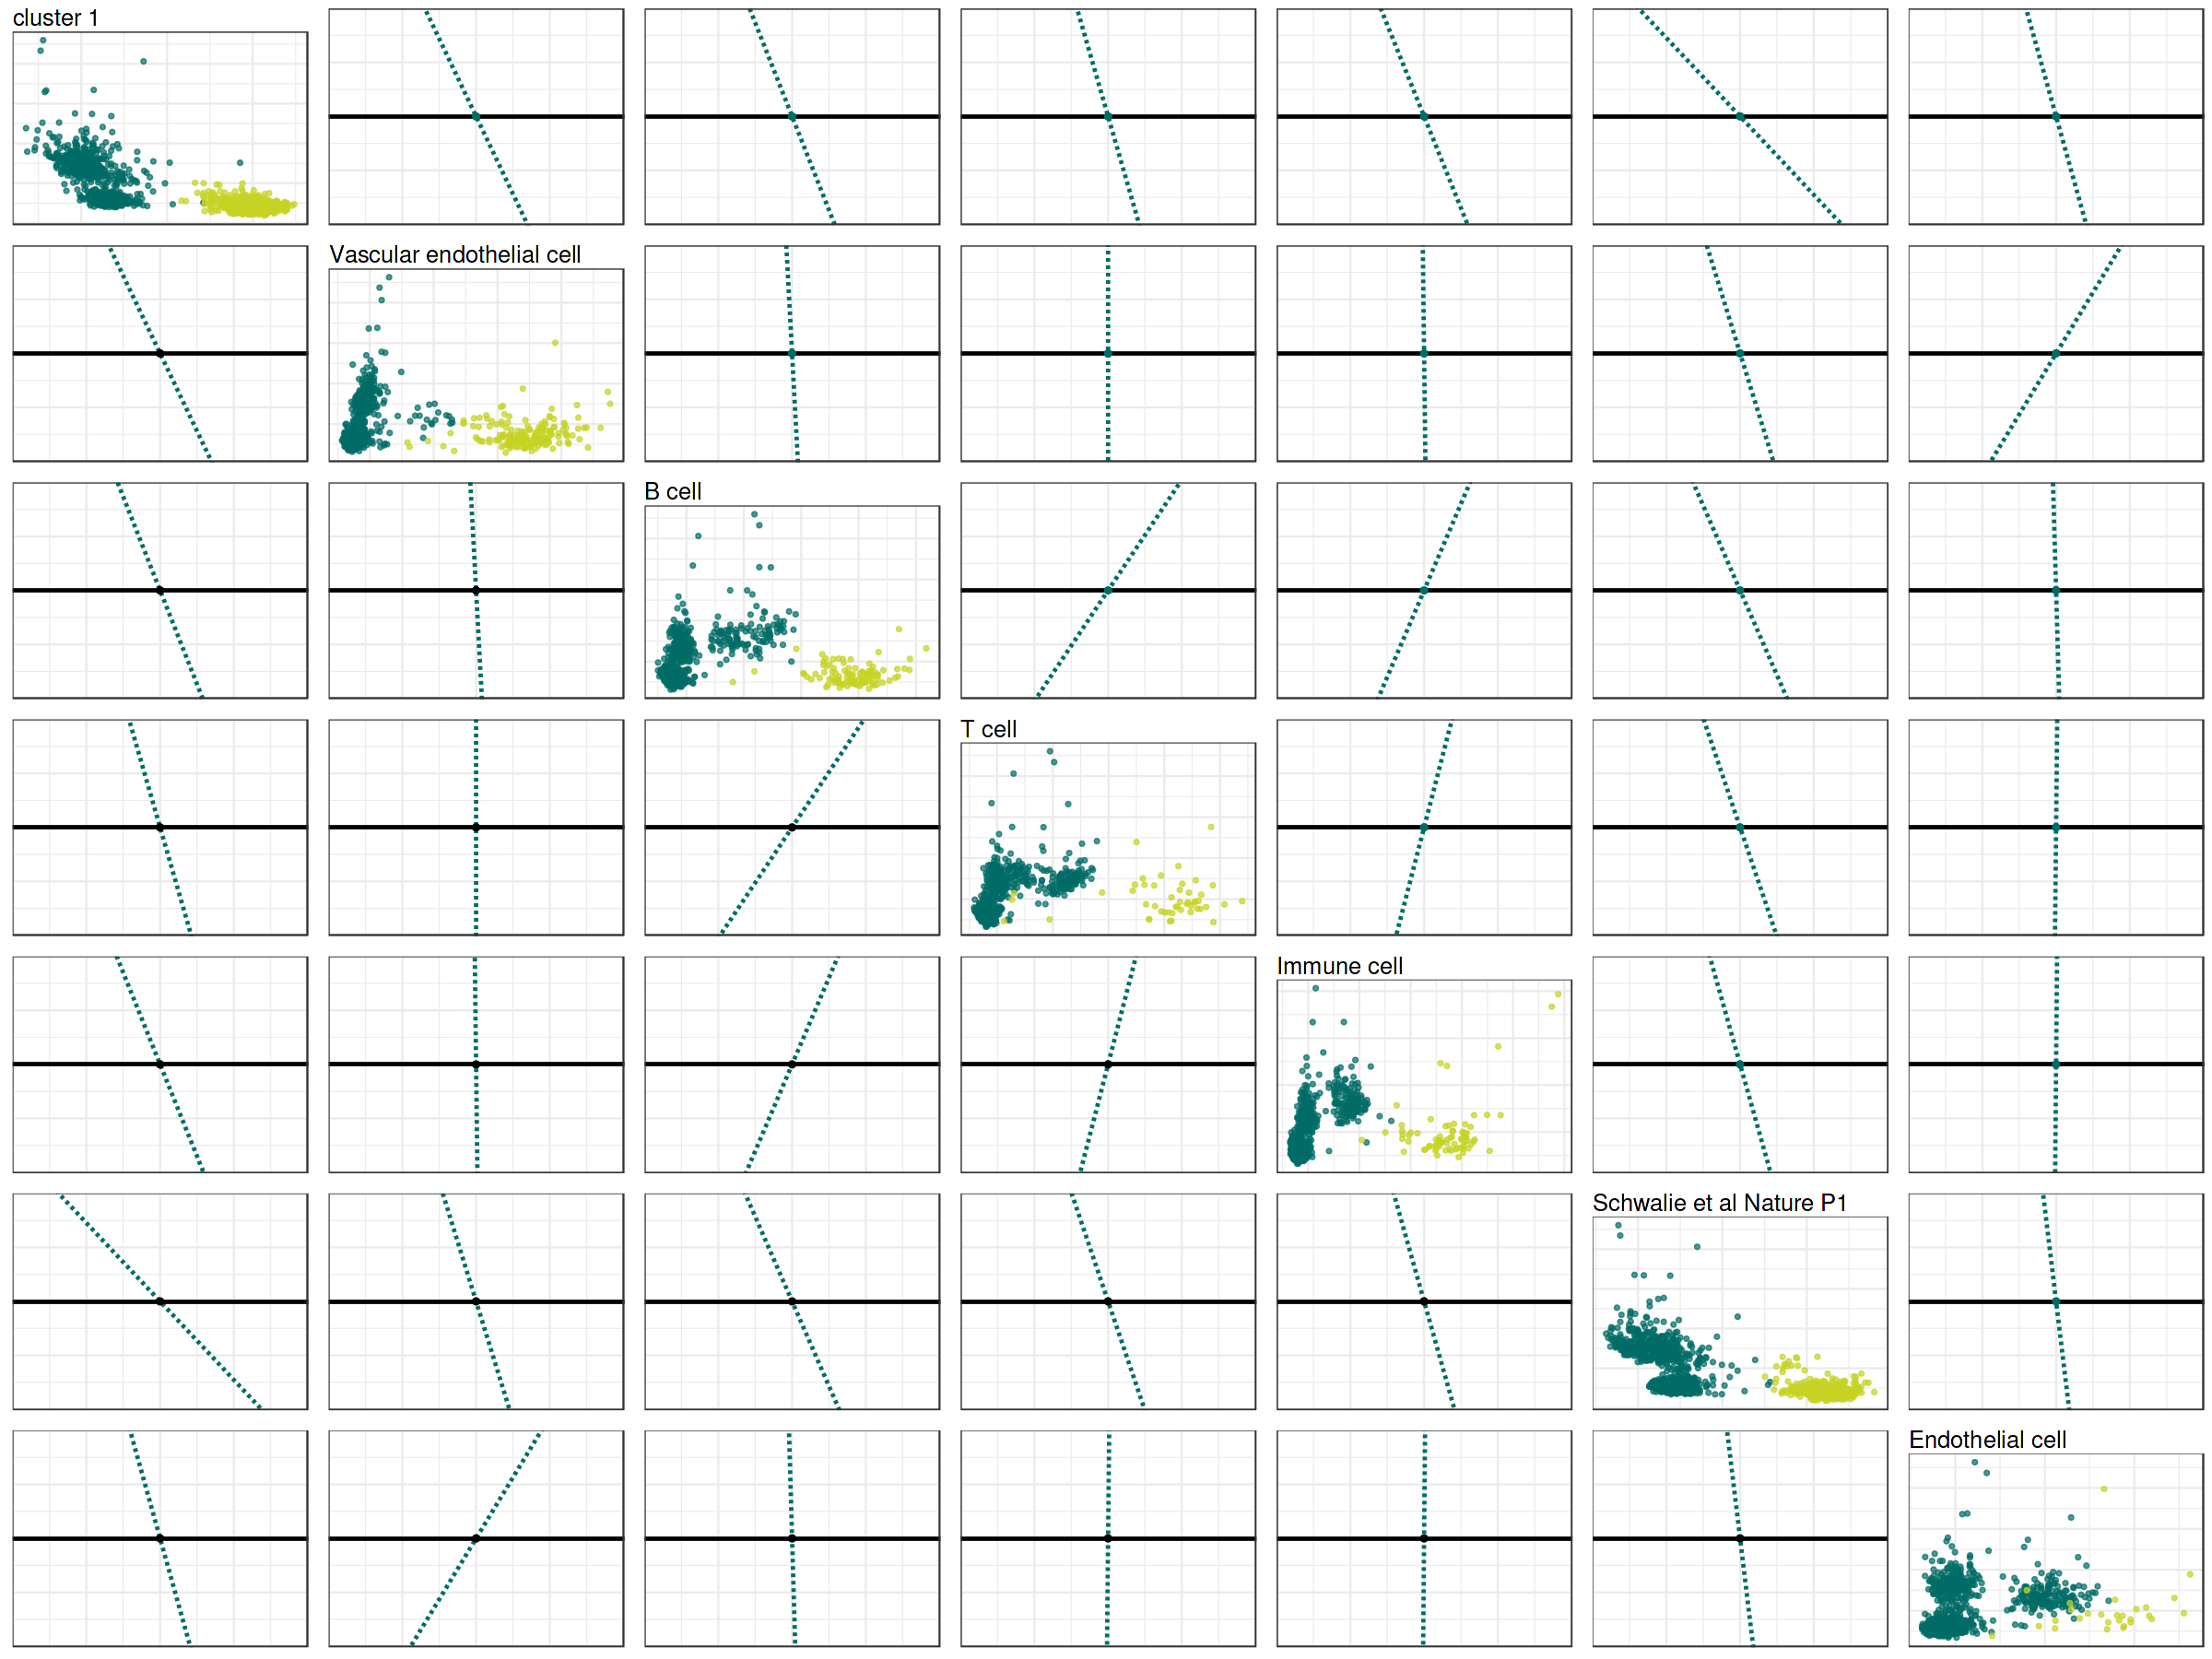

In [18]:
pr <- plot_results(cak, ca, title_prefix = "", gsub_title = "_|\\.", return_list = TRUE)

pr <- lapply(
  pr,
  FUN = function(p) {
    p + theme(
      plot.title = ggtext::element_textbox_simple(size = 15)
    )
  })

pr <- ggpubr::ggarrange(
  plotlist = pr,
  nrow = sqrt(length(pr)),
  ncol = sqrt(length(pr))
)

ggsave(
  plot = pr,
  filename = file.path(imgdir, "summary_results.pdf"),
  width = 3400,
  height = 3400,
  units = "px"
)

pr

# Session Info

In [19]:
sessionInfo()

R version 4.4.0 (2024-04-24)
Platform: x86_64-pc-linux-gnu
Running under: MarIuX64 2.0 GNU/Linux

Matrix products: default
BLAS:   /pkg/R-4.4.0-0/lib/R/lib/libRblas.so 
LAPACK: /usr/lib/liblapack.so.3.10.1

locale:
 [1] LC_CTYPE=en_US.UTF-8 LC_NUMERIC=C         LC_TIME=C           
 [4] LC_COLLATE=C         LC_MONETARY=C        LC_MESSAGES=C       
 [7] LC_PAPER=C           LC_NAME=C            LC_ADDRESS=C        
[10] LC_TELEPHONE=C       LC_MEASUREMENT=C     LC_IDENTIFICATION=C 

time zone: Europe/Berlin
tzcode source: system (glibc)

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] ggsankey_0.0.99999          ggtext_0.1.2               
 [3] patchwork_1.2.0             scran_1.32.0               
 [5] scater_1.32.0               ggplot2_3.5.1              
 [7] scuttle_1.14.0              Seurat_5.0.1               
 [9] SeuratObject_5.0.2          sp_2.1-4                   
[11] TENxPBMC